# Tech Challenger - Fase 2


O comando abaixo baixa as bibliotecas nas versões que foram usadas nesse projeto, caso queira executar o notebook é importante criar um virtualenv no seu ambiente.
na documentação oficial do python a seguir tem o passo a passo 
https://docs.python.org/pt-br/3/library/venv.html

In [ ]:
!pip install -r requirements.txt

## Importando as bibliotecas

In [1425]:
import arch
import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from prophet import Prophet
import scipy.stats as stats
from termcolor import colored
from matplotlib import rcParams
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

## Tabela de Utilidades das Bibliotecas Importadas



| Biblioteca | Descrição | 
|---|---|
| arch | Modelagem de processos ARCH (Autoregressive Conditional Heteroskedasticity) para séries temporais financeiras. |
| holidays | Identifica feriados em diferentes países. |
| numpy (np) | Biblioteca fundamental para operações matemáticas e manipulação de arrays multidimensionais. |
| pandas (pd) |  Biblioteca para análise e manipulação de dados em DataFrames e Series. |
| seaborn (sns) |  Criação de visualizações estatísticas de alta qualidade com base em Matplotlib. |
| xgboost (xgb) | Implementação altamente performática do algoritmo XGBoost para tarefas de aprendizagem supervisionada (regressão e classificação). |
| pmdarima (pm) | Modelagem de séries temporais com modelos ARIMA (Autoregressive Integrated Moving Average) e SARIMA (Seasonal ARIMA) automatizados. |
| date | Manipulação de datas. |
| prophet | Biblioteca para previsão de séries temporais baseada no algoritmo Prophet do Facebook. | 
| scipy.stats (stats) | Funções estatísticas avançadas como testes de hipótese e distribuições de probabilidade. |
| termcolor | Impressão de texto colorido no terminal. |
| matplotlib (plt) | Biblioteca poderosa para criação de gráficos e visualização de dados. |
| rcParams | Funções para configuração global de parâmetros do Matplotlib. |
| prettytable | Criação de tabelas legíveis e formatadas para impressão no terminal. |
| pmdarima.arima.auto_arima | Função para identificação automática de modelos ARIMA para séries temporais. |
| statsmodels.tsa.arima.model.ARIMA | Classe para implementação manual de modelos ARIMA. |
| statsmodels.tsa.stattools  | Funções para testes de estacionariedade de séries temporais (ADF, KPSS). |
| statsmodels.tsa.seasonal | Função para decomposição sazonal de séries temporais. |
| statsmodels.graphics.tsaplots | Funções para plotagem de funções de autocorrelação (ACF) e autocorrelação parcial (PACF) de séries temporais. |
| sklearn.metrics | Funções para cálculo de métricas de erro em tarefas de previsão (MAE, RMSE, MAPE). |



|---|---|
| arch | Modelagem de processos ARCH (Autoregressive Conditional Heteroskedasticity) para séries temporais financeiras. |
| holidays | Identifica feriados em diferentes países. |
| numpy (np) | Biblioteca fundamental para operações matemáticas e manipulação de arrays multidimensionais. |
| pandas (pd) |  Biblioteca para análise e manipulação de dados em DataFrames e Series. |
| seaborn (sns) |  Criação de visualizações estatísticas de alta qualidade com base em Matplotlib. |
| xgboost (xgb) | Implementação altamente performática do algoritmo XGBoost para tarefas de aprendizagem supervisionada (regressão e classificação). |
| pmdarima (pm) | Modelagem de séries temporais com modelos ARIMA (Autoregressive Integrated Moving Average) e SARIMA (Seasonal ARIMA) automatizados. |
| date | Manipulação de datas. |
| prophet | Biblioteca para previsão de séries temporais baseada no algoritmo Prophet do Facebook. | 
| scipy.stats (stats) | Funções estatísticas avançadas como testes de hipótese e distribuições de probabilidade. |
| termcolor | Impressão de texto colorido no terminal. |
| matplotlib (plt) | Biblioteca poderosa para criação de gráficos e visualização de dados. |
| rcParams | Funções para configuração global de parâmetros do Matplotlib. |
| prettytable | Criação de tabelas legíveis e formatadas para impressão no terminal. |
| pmdarima.arima.auto_arima | Função para identificação automática de modelos ARIMA para séries temporais. |
| statsmodels.tsa.arima.model.ARIMA | Classe para implementação manual de modelos ARIMA. |
| statsmodels.tsa.stattools  | Funções para testes de estacionariedade de séries temporais (ADF, KPSS). |
| statsmodels.tsa.seasonal | Função para decomposição sazonal de séries temporais. |
| statsmodels.graphics.tsaplots | Funções para plotagem de funções de autocorrelação (ACF) e autocorrelação parcial (PACF) de séries temporais. |
| sklearn.metrics | Funções para cálculo de métricas de erro em tarefas de previsão (MAE, RMSE, MAPE). |



## Definições Padrões para uso do matplotlib

In [1426]:
rcParams['figure.figsize'] = 12, 5

A configuração acima foi definida para manter a escala de 12 por 5 para todos os plot do projeto

# Importando os dados do IBOVESPA 

In [1427]:
df = pd.read_csv("Ibovespa 2004 a 2024.csv", sep=',')
df

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,12.03.2024,127.668,126.124,128.039,126.121,"9,48M","1,22%"
1,11.03.2024,126.124,127.068,127.068,126.065,"8,90M","-0,75%"
2,08.03.2024,127.071,128.335,128.338,125.802,"11,94M","-0,99%"
3,07.03.2024,128.340,128.890,129.188,128.033,"7,35M","-0,43%"
4,06.03.2024,128.890,128.099,129.323,128.099,"11,06M","0,62%"
...,...,...,...,...,...,...,...
4995,08.01.2004,23.717,23.334,23.718,23.122,"436,74M","1,70%"
4996,07.01.2004,23.320,23.576,23.899,23.320,"464,08M","-1,09%"
4997,06.01.2004,23.576,23.532,23.976,23.180,"472,38M","0,19%"
4998,05.01.2004,23.532,22.445,23.532,22.445,"496,71M","4,84%"


#### Os dados acima foram importados do site investing através do link (https://br.investing.com/indices/bovespa-historical-data) conforme solicitado no tech challenger

In [1428]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,12.03.2024,127.668,126.124,128.039,126.121,"9,48M","1,22%"
1,11.03.2024,126.124,127.068,127.068,126.065,"8,90M","-0,75%"
2,08.03.2024,127.071,128.335,128.338,125.802,"11,94M","-0,99%"
3,07.03.2024,128.340,128.890,129.188,128.033,"7,35M","-0,43%"
4,06.03.2024,128.890,128.099,129.323,128.099,"11,06M","0,62%"


> Visualização das 5 primeiras linhas

In [1429]:
df.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
4995,08.01.2004,23.717,23.334,23.718,23.122,"436,74M","1,70%"
4996,07.01.2004,23.320,23.576,23.899,23.320,"464,08M","-1,09%"
4997,06.01.2004,23.576,23.532,23.976,23.180,"472,38M","0,19%"
4998,05.01.2004,23.532,22.445,23.532,22.445,"496,71M","4,84%"
4999,02.01.2004,22.445,22.233,22.450,22.208,"136,42M","0,94%"


#### Visualização das 5 ultimas linhas

In [1430]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5000 non-null   object 
 1   Último    5000 non-null   float64
 2   Abertura  5000 non-null   float64
 3   Máxima    5000 non-null   float64
 4   Mínima    5000 non-null   float64
 5   Vol.      4999 non-null   object 
 6   Var%      5000 non-null   object 
dtypes: float64(4), object(3)
memory usage: 273.6+ KB


#### Visualização das informações da tabela, foi notado que o campo data está como objet em vez de datetime[ns]

In [1431]:
df.describe()

,Último,Abertura,Máxima,Mínima
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,67.437202,67.416755,68.087605,66.752167
std,28.529050,28.523403,28.714507,28.333544
min,17.604000,17.607000,18.387000,17.601000
25%,49.223250,49.220750,49.805000,48.578750
50%,60.956000,60.954500,61.551000,60.190500
75%,87.888000,87.850250,88.529500,86.841750
max,134.194000,134.194000,134.392000,133.832000


#### Visualização de dados estastistico basico da base

# Tratamento de dados

#### A partir do dataframe DF foi criado uma Serie Fechamento, o campo data foi formatado para datetime e definido como index da serie

In [1432]:
serie_fechamento = pd.Series(data=df['Último'].values, index=pd.to_datetime(df['Data'], format='%d.%m.%Y'))
serie_fechamento = serie_fechamento.sort_index(ascending=True)
serie_fechamento

Data
2004-01-02     22.445
2004-01-05     23.532
2004-01-06     23.576
2004-01-07     23.320
2004-01-08     23.717
               ...   
2024-03-06    128.890
2024-03-07    128.340
2024-03-08    127.071
2024-03-11    126.124
2024-03-12    127.668
Length: 5000, dtype: float64

# Avaliando os dados

#### Foi criado um método para protar series, assim podendo ser reutilizado sempre que precisar plotar uma serie, podendo passar a serie, titulo e as legendas em formato de lista

In [1433]:
def plotarSerie(serie, titulo="Valores da bolsa de valores com base no fechamento diário", legendas=[]):
    serie.plot()    
    plt.title(titulo)
    plt.xlabel('Data')
    plt.grid(visible=True, linestyle='-', linewidth=0.7)
    plt.ylabel('Valor em Real (R$)')
    if legendas:
        plt.legend(labels=legendas, loc='best')

#### Feito um primeiro plot utilizando o metodo *plotarSerie(serie, titulo, legendas)* para a serie fechamento

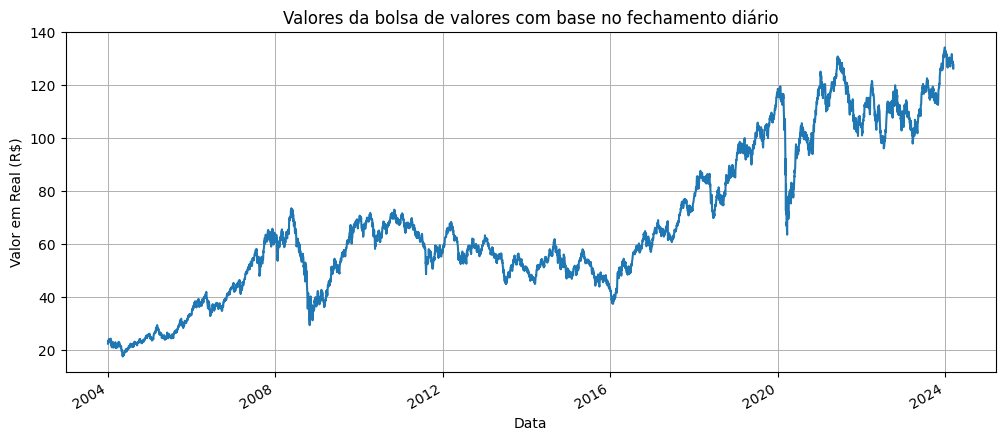

In [1434]:
plotarSerie(serie_fechamento)

#### Já é possível notar que a serie tem tendencia de crescimento e a principio não aparenta ser uma serie estácionaria, devido sua crescente ao longo do tempo

#### A seguir, foi desenvolvido um novo método que irá gerar gráficos da série temporal, incluindo a média móvel mensal, trimestral e anual.
> Obs: estamos considerando que os dias uteis do mes são 22 dias. portanto os numeros do metódo são baseado em dias úteis


In [1435]:
def plotar_medias_moveis(serie, titulo ='Valores da bolsa de valores com média movel' ):
    dias_uteis = 22
    serie_media_movel_30 = serie.rolling(dias_uteis).mean()
    serie_media_movel_90 = serie.rolling(dias_uteis * 3).mean()
    serie_media_movel_anual = serie.rolling(dias_uteis * 12).mean()
    plotarSerie(serie)
    plotarSerie(serie_media_movel_30)
    plotarSerie(serie_media_movel_90)
    plotarSerie(serie_media_movel_anual, titulo ,['Valor Real','Média movel mensal', 'Média Móvel trimestral', 'Média Móvel Anual'])
    plt.show()

### Utilizando o método acima, iremos protar a serie_fechamento para visualizar a seria juntamente com suas médias

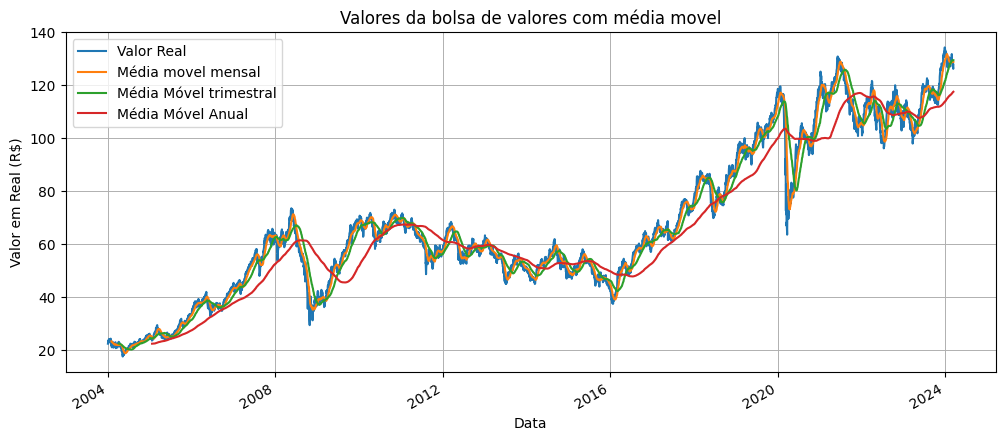

In [1436]:
plotar_medias_moveis(serie_fechamento)

### Agora que já visualizamos os dados, vamos entender como está a distribuição dos dados

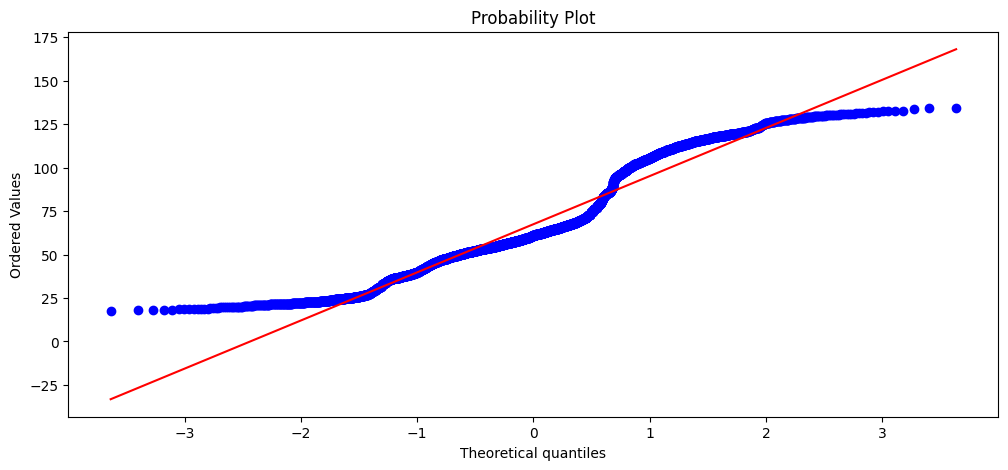

In [1437]:
stats.probplot(serie_fechamento, dist='norm', plot=plt)
plt.show()

\- Avaliando a distribuição de dados Q-Q plot (quantile-quantile plot), é possível notar que a distribução dos dados não está normalizada, o esperado é que os pontos azuis, estivessem muitos proximos da linha vermelha. Neste gráfico, os dados começam a se alinhar com a linha vermelha nos quantis intermediários, mas desviam-se nas caudas (extremos), indicando que a distribuição dos dados pode não ser perfeitamente normal.

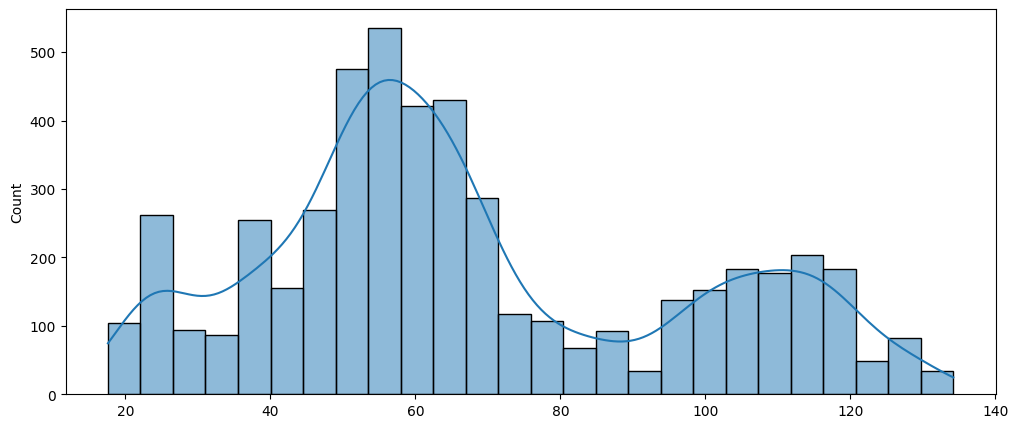

In [1438]:
sns.histplot(serie_fechamento, kde=True)
plt.show()

\- Uma segunda forma de avaliação é utilizando o histograma, nele é possível visualizar que existem picosem torno dos 20 60 e 110, aparenta ter grupos distintos de dados ou várias distribuições sobre postas, confirmando que os dados não seguem uma distribuição normal. um grafico de distribuição normal, tem uma aparencia em formato de um sino.

## Test de normalidade

\- Muitas vezes as observações de um grafico aparenta ter uma distribuição normais, mas isso não garante que os dados tenho uma distribuição normal, para garantir a distribuição podemos fazer o teste de **Shapiro Wilk**.

## Teste Shapiro-Wilk

### O que é o teste de Shapiro-Wilk?

    O teste de Shapiro-Wilk é uma ferramenta estatística utilizada para avaliar se um conjunto de dados se ajusta a uma distribuição normal. A distribuição normal, também conhecida como curva em forma de sino, é uma das distribuições mais comuns em estatística e é frequentemente utilizada em diversos modelos estatísticos.

#### Por que é importante testar a normalidade?

    Muitos testes estatísticos assumem que os dados seguem uma distribuição normal. Se essa premissa não for verdadeira, os resultados do teste podem ser enganosos. Ao realizar o teste de Shapiro-Wilk, você verifica se essa suposição é razoável para seus dados.

Critérios:

Nível de significância de 0,05 ou 5% (mais utilizado)

Valor de p < 0.05: Os dados provavelmente não são normalmente distribuídos.
Valor de p ≥ 0.05: Não há evidência suficiente para rejeitar a hipótese de normalidade.

### Abaixo criamos um método que calcula a partir de uma serié se a distribuição é normal ou não

In [1439]:
def validacao_distribuicao(serie):
    print(colored(':: Validação Distribuição (Shapiro-Wilk) ::', 'light_blue', attrs=["bold"]))
    e, p = stats.shapiro(serie)
    print(f'Estátistica do teste: {e}')
    print(f'p-valor: {p}')
    if p > e:
        print(colored('>> Distribuição Normal <<','green'))
    else:
        print(colored('Não há evidência suficiente para rejeitar a hipótese de normalidade','red'))


In [1440]:
validacao_distribuicao(serie_fechamento)

:: Validação Distribuição (Shapiro-Wilk) ::
Estátistica do teste: 0.9403685462961359
p-valor: 6.571910093211889e-41
Não há evidência suficiente para rejeitar a hipótese de normalidade


\- Foi executado o teste de **Shapiro Wilk** e foi constatado que não há uma distribuição normal, mas podemos tentar buscar uma normalidade através de transformação logaritmica ou transformação de raiz quadrada ou cubica


# Técnicas de Transformação para Normalização


Para transformar os dados visando uma normalização (ou aproximação de uma distribuição normal), você pode tentar diferentes técnicas de transformação. Aqui estão algumas abordagens comuns:


### 1. Transformação Logarítmica
Utilizada para reduzir a assimetria positiva (cauda longa à direita).

\[
    $y' = \log(y)$
\]

**Uso**: Quando os dados possuem muitos valores altos que puxam a média.

---

### 2. Transformação de Raiz Quadrada ou Cúbica
Suaviza variações em dados positivos e assimétricos.

\[
$y' = \sqrt{y}$
\]


## Aplicando a transformação com Logarítmica

In [1441]:
serie_log = np.log(serie_fechamento)
serie_log.head()

Data
2004-01-02    3.111068
2004-01-05    3.158361
2004-01-06    3.160229
2004-01-07    3.149311
2004-01-08    3.166192
dtype: float64

[]

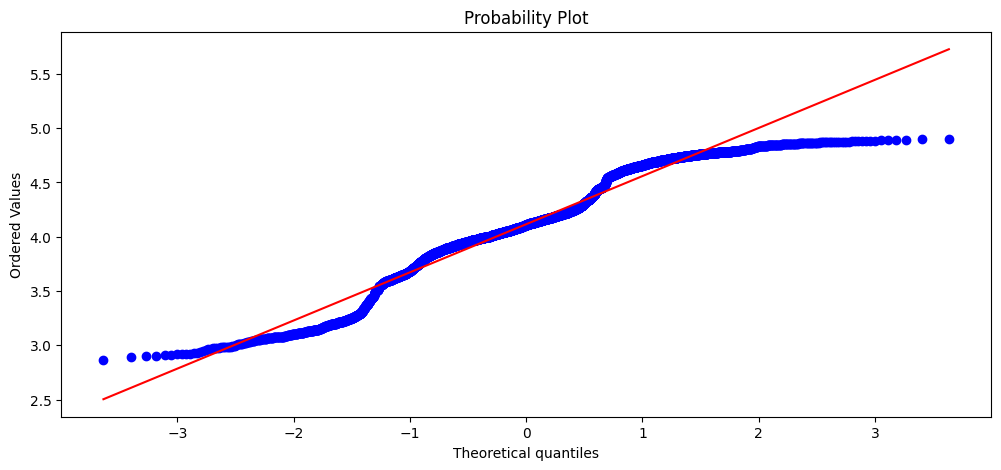

In [1442]:
stats.probplot(serie_log, dist='norm', plot=plt)
plt.plot()

<Axes: ylabel='Count'>

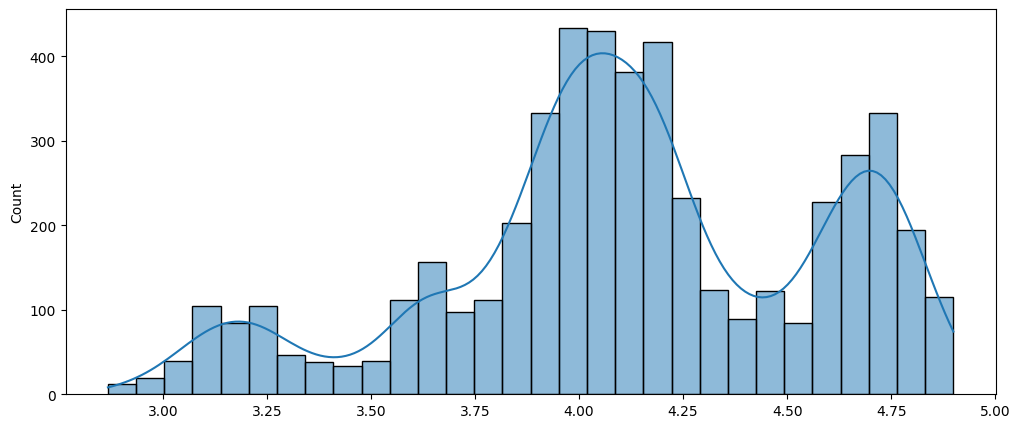

In [1443]:
sns.histplot(serie_log, kde=True)

- Após a transformações a distribuição foi modificada, porem não teve bons resultados, pois ela ainda não teve sua distribuição normalizada, iremos aplica a validação de shapiro para confirmação

In [1444]:
validacao_distribuicao(serie_log)

:: Validação Distribuição (Shapiro-Wilk) ::
Estátistica do teste: 0.9597856085568828
p-valor: 4.0735574502465716e-35
Não há evidência suficiente para rejeitar a hipótese de normalidade


    - Mesmo efetuando transformação em logaritmo não foi possível obter um bom resultado

## Aplicando Transformação de Raiz Quadrada ou Cúbica

Iremos elevar ao cubo para tentar obter uma melhor distribuição, usaremos o sign e abs para evitar o valores negativos

In [1445]:
serie_ao_cubo = np.sign(serie_fechamento)*abs(serie_fechamento)**(1/3)
serie_ao_cubo.head()

Data
2004-01-02    2.820806
2004-01-05    2.865627
2004-01-06    2.867412
2004-01-07    2.856995
2004-01-08    2.873117
dtype: float64

[]

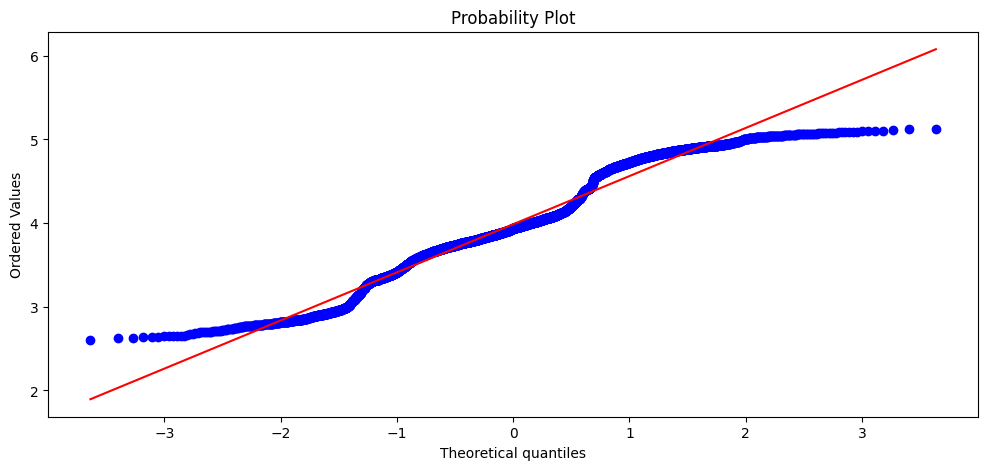

In [1446]:
stats.probplot(serie_ao_cubo, dist='norm', plot=plt)
plt.plot()

[]

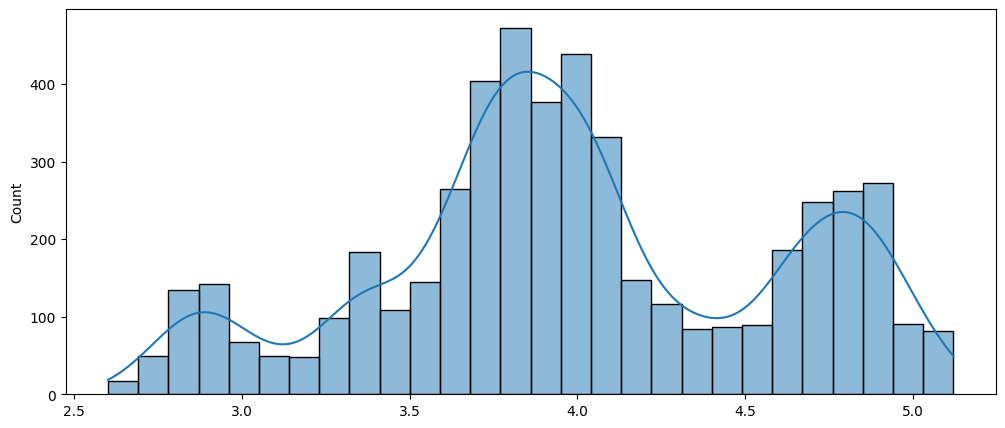

In [1447]:
sns.histplot(serie_ao_cubo, kde=True)
plt.plot()

In [1448]:
validacao_distribuicao(serie_ao_cubo)

:: Validação Distribuição (Shapiro-Wilk) ::
Estátistica do teste: 0.967088326048236
p-valor: 2.3955996920333463e-32
Não há evidência suficiente para rejeitar a hipótese de normalidade


- Mesmo fazendo a transformação para Não foi possível obter a distribuição normal usando serie ao cubo

# Decomposição

#### Decompondo a serie fechamento

- Vamos começar a avaliar os dados separadamente, com objetivo de isolar os componentes para uma analise mais individual o que irá ajuda a identificar o que está impulsionando o comportamento da série, como padrões sazonais ou uma tendência geral.

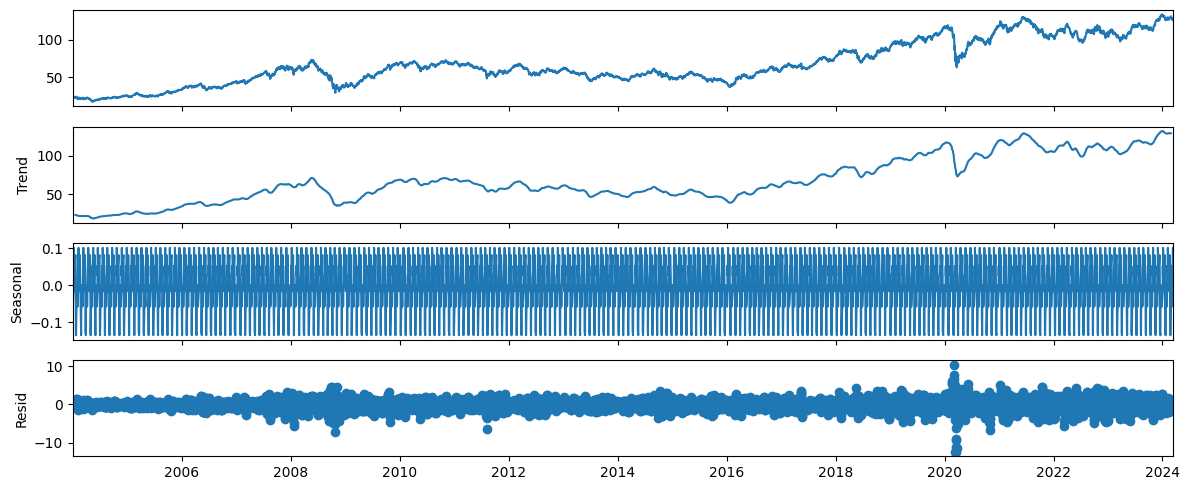

In [1449]:
serie_decomposta = seasonal_decompose(serie_fechamento, period=22)
serie_decomposta.plot()
plt.tight_layout()

O grafico a acima demonstra uma tendencia crescente ao longo do tempo, mas a sanonalidade fica dificil de avaliar, portanto vamos aumentar o periodo para melhorar a visualização da sazonalidade 

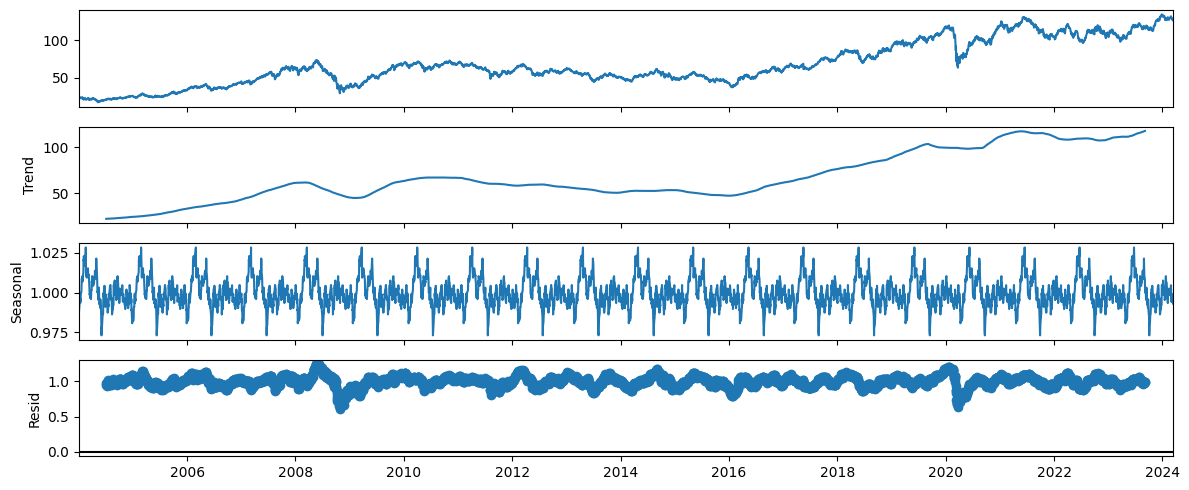

In [1450]:
serie_decomposta = seasonal_decompose(serie_fechamento, model="multiplicative", period=252)
serie_decomposta.plot()
plt.tight_layout()

- Após aumentar o periodo foi possível identificar melhor que existe uma sazonalidade entre os dados e os residuos tambem ficou mais claro
- Os resíduos representam o ruído da série temporal, ou seja, as variações que não são previsíveis com base nos componentes sistemáticos (tendência e sazonalidade, por exemplo). Essas flutuações podem ser devidas a eventos externos, fatores aleatórios ou variações de curto prazo.
- Tantos nos dados observados, tendencia e nos residos é possível notar duas quedas, entre os anos de 2008-2009 e 2020.
- Essas quedas foram acometidas por eventos que impactou a economia mundial, sendo o primeiro deles em 2008 que ocorreu a **crise financeira global** esse evento teve um impacto profundo na economia global e nos mercados financeiros, levando a uma das maiores quedas nas bolsas de valores em todo o mundo desde a Grande Depressão de 1929.
- E em 2020 foi a *pandemia* do da COVID-19. A disseminação rápida do novo coronavírus **(SARS-CoV-2)** causou uma crise global de saúde pública, levando a grandes incertezas econômicas e a um colapso nos mercados financeiros. A crise desencadeada pela COVID-19 afetou praticamente todas as economias e setores ao redor do mundo.

- Para uma observação mais proximas dos dias atuais, iremos observar a sazonalidade nos seus ultimos 500 dias equivalente a 2 anos

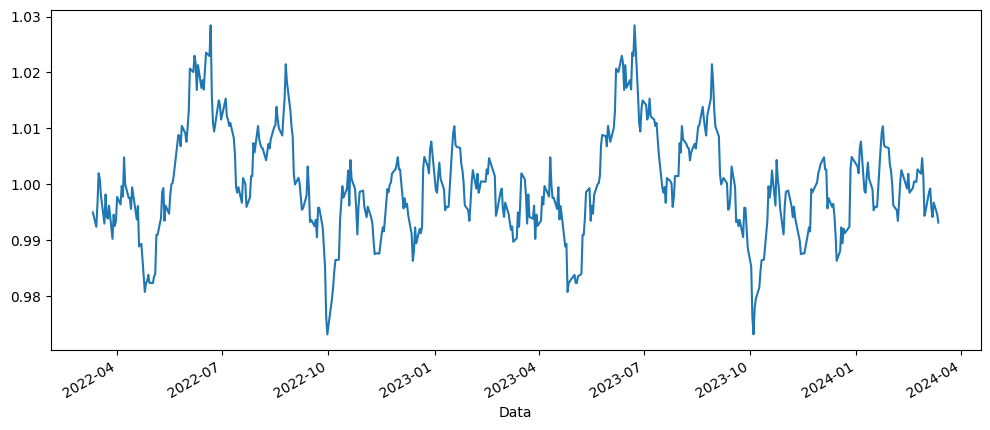

In [1451]:
serie_decomposta.seasonal.iloc[-500:].plot()
plt.show()

em 2 anos é possível notar que existe uma sazonalidade entre esse periodo observado

# Estacionaridade

A **estacionaridade** é um conceito fundamental em séries temporais e análises estatísticas, pois tem implicações significativas para a modelagem e previsão de dados.

- Uma série temporal é dita estacionária se suas propriedades estatísticas, como média, variância e autocovariância, permanecem constantes ao longo do tempo. Isso significa que as flutuações e padrões observados em uma parte da série serão semelhantes em outras partes.
- Muitos modelos estatistico  pressupoe que os dados são estacionários, tendo assim uma previsão mais precisa sobre os dados
- A **estacionaridade** permite detectar padrões tendencias e sazonalidades que são essenciais para analise e previsão

Através da decomposição é possível notar que existe uma sazonalidade e uma tendencia de crescimento, que aparenta não ser estácionada.
Para validar iremos um o test de KPSS e Dict Fuller

## Teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin)

- O teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin) é um método estatístico para verificar a estacionaridade de séries temporais. Sua hipótese nula assume que a série é estacionária, enquanto a alternativa sugere que é não estacionária. O teste calcula um estatístico KPSS com base nos resíduos da série e compara com valores críticos para tomar decisões. Se o valor calculado for maior que o crítico, rejeita-se a estacionaridade. É amplamente utilizado em análises econômicas e financeiras para validar a adequação de modelos que presumem estacionaridade.

- Assumos então os seguintes critérios: 

> Ho = não é estacionário: estatística do teste > valor crítico

> Ha = é estacionário:  estatística do teste < valor crítico

#### Validação KPSS

    Para facilitar o reuso criamos um metodo que valida se a serie é ou não estacionária e exibe os valores estatisticos e criticos do teste

In [1452]:
def validacao_kpss(serie):
    print(colored(':: Validação KPSS (Kwiatkowski-Phillips-Schmidt-Shin) ::', 'light_blue', attrs=["bold"]))
    resultado = kpss(serie)
    estatistica_teste = resultado[0]
    p_valor = resultado[1]
    valores_criticos  = resultado[3]
    percentil_referencia = '5%'

    print(f'Estatística do teste: {estatistica_teste:.4f}')
    print(f'p-valor {p_valor:.4f}')
    print('Valores Críticos:')
    table = PrettyTable(['Criticidade', 'Valor'])

    for chave, valor in valores_criticos.items():
        table.add_row([chave, valor])
    
    print(table)

    if estatistica_teste > valores_criticos[percentil_referencia]:
        print(colored('>> Serie não estacionária <<', 'red'))
    else:
        print(colored('>> Série estácionaria <<', 'green'))


#### Aplicando a validação KPSS

In [1453]:
validacao_kpss(serie_fechamento)

:: Validação KPSS (Kwiatkowski-Phillips-Schmidt-Shin) ::
Estatística do teste: 8.9275
p-valor 0.0100
Valores Críticos:
+-------------+-------+
| Criticidade | Valor |
+-------------+-------+
|     10%     | 0.347 |
|      5%     | 0.463 |
|     2.5%    | 0.574 |
|      1%     | 0.739 |
+-------------+-------+
>> Serie não estacionária <<


C:\Users\Will\AppData\Local\Temp\ipykernel_7616\4087432485.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  resultado = kpss(serie)


- Na aplicação da serie fechamento foi identificada que ela não é estacionária, pois o valor este estátistico é maior que o valor critico

### Teste ADF (Dickey-Fuller)

* O teste de Dickey-Fuller é uma ferramenta estatística usada para verificar se uma série temporal possui raiz unitária, ou seja, se ela é estacionária. 
* A estacionariedade é importante para a aplicação de muitos modelos econométricos. O teste compara uma estatística calculada com um valor crítico. Se a estatística for menor que o valor crítico, rejeitamos a hipótese de raiz unitária e concluímos que a série é estacionária. 
* O teste de Dickey-Fuller aumentado (ADF) é a versão mais comum e inclui termos de defasagem para capturar a autocorrelação. A não estacionariedade pode levar a resultados enganosos em modelos econométricos e comprometer a qualidade das previsões.

> H0: Se a estatística de teste for menor que o valor crítico, rejeitamos a hipótese nula e concluímos que a série é estacionária.
> H0: Se a estatística de teste for maior ou igual ao valor crítico, não rejeitamos a hipótese nula e concluímos que a série pode ter raiz unitária (ou seja, não há evidências suficientes para afirmar que ela é estacionária).

Usaremos como valor de referencia 5%

Resumo: 
- p-valor > 0.05  
    - Se p-valor for maior que o valor de referencia: Não rejeitar a Hipótese Nula: a série não é estacionária 
- p-valor < 0.05
    - se p-valor for menor que o valor de referencia: Rejeitar a Hipótese Nula: a série é estacionária

In [1454]:
def validacao_adfuller(serie):
  print(colored(':: Validação ADF (Dickey-Fuller) ::', 'light_blue', attrs=["bold"]))
  result_adf = adfuller(serie)
  statistic_value = result_adf[0]
  p_value = result_adf[1]
  critical_values =  result_adf[4]
  valor_referencia = 0.05

  print(f"ADF Statistic: {statistic_value}")
  print(f'Valor-p do Teste ADF: {p_value}')

  table = PrettyTable(['Criticidade','Valor'])
  for key, value in critical_values.items():
    table.add_row([key, value])

  print(table)

  if p_value > valor_referencia:
    print(colored('Não rejeitar a Hipótese Nula: a série não é estacionária\n','red'))
  else:
    print(colored('Rejeitar a Hipótese Nula: a série é estacionária\n','green'))

In [1455]:
validacao_adfuller(serie_fechamento)

:: Validação ADF (Dickey-Fuller) ::
ADF Statistic: -1.0890536425095538
Valor-p do Teste ADF: 0.7194173863860649
+-------------+---------------------+
| Criticidade |        Valor        |
+-------------+---------------------+
|      1%     |  -3.43166168173001  |
|      5%     | -2.8621196211801374 |
|     10%     | -2.5670785331097763 |
+-------------+---------------------+
Não rejeitar a Hipótese Nula: a série não é estacionária



Usamos o teste de ADF para validar se a serie é ou não estacionária e foi respondido que a serie nao é estácionaria

#### Avaliando a autocorrelação

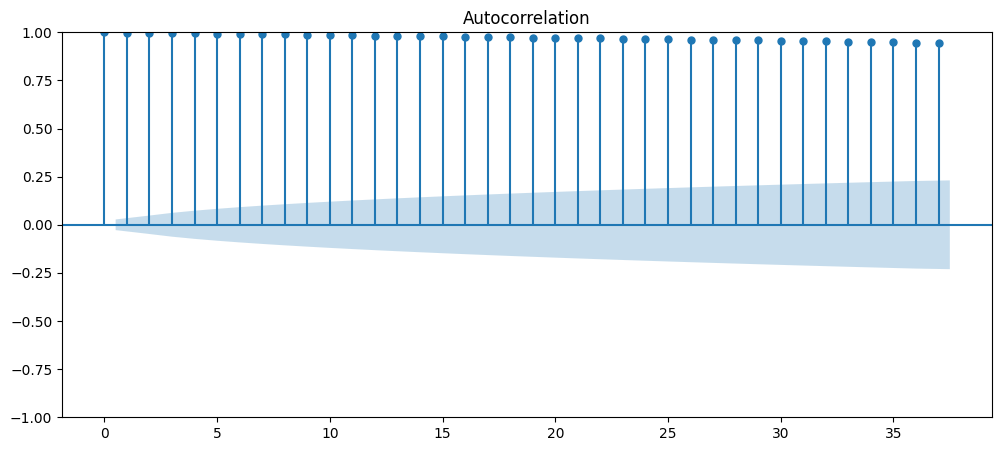

In [1456]:
plot_acf(serie_fechamento)
plt.show()

- As barras verticais mostram os valores de autocorrelação muito próximos de 1 para todos os lags, exibindo um sinal claro que a série não é estacionária, isso demonstram um padrão de decaimento lento ou até mesmo ausencia de decaimento, como a autocorrelação mantem um valor elevado demonstra que existe uma forte dependencia temporal entre os pontos da série

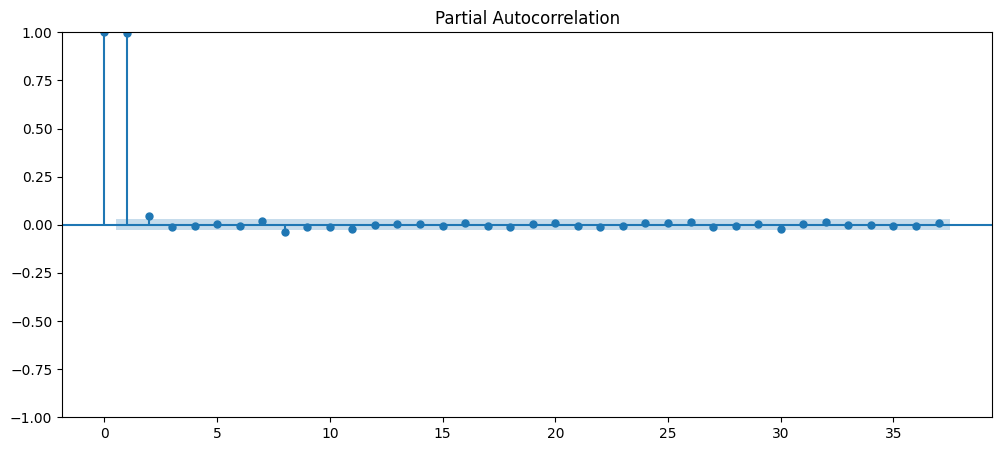

In [1457]:
plot_pacf(serie_fechamento)
plt.show()

- A autocorrelação parcial apresenta que o valor atual da série está formente relacionado ao valor anterior, com essa informação é possível notar que os valores mais distantes no passado tem pouca influencia na previsão do valor atual

Após todas as analises concluimos que a serie não é estácionaria e que nessecitamos transforma-las em estacionarias para conseguir ter um melhor aproveitamento dos modelos que iremos criar, então iremos aplicar a  técnica de diferenciação

# Diferenciação

- A técnica de diferenciação é uma técnica utilizada para transformar uma série temporal não estacionária em uma série estacionária.
- Ela consiste em subtrair o valor de uma observação do valor da observação anterior. Essa operação remove tendências e sazonalidades presentes na série original, tornando-a mais adequada para a aplicação de modelos econométricos e de previsão. 
- Ao diferenciar uma série, estamos analisando a taxa de variação ao invés dos níveis absolutos dos dados.

#### Aplicando Diferenciação

In [1458]:
serie_fechamento_diff = serie_fechamento.diff()
serie_fechamento_diff = serie_fechamento_diff.dropna()
serie_fechamento_diff

Data
2004-01-05    1.087
2004-01-06    0.044
2004-01-07   -0.256
2004-01-08    0.397
2004-01-09    0.200
              ...  
2024-03-06    0.792
2024-03-07   -0.550
2024-03-08   -1.269
2024-03-11   -0.947
2024-03-12    1.544
Length: 4999, dtype: float64

- Foi aplicado a diferenciação e excluido a primeira linha que estava nula, justamente porque na diferenciação se perde o primeiro valor, pois ele não teve nenhum valor para comparar com o anterior tornando-se nulo

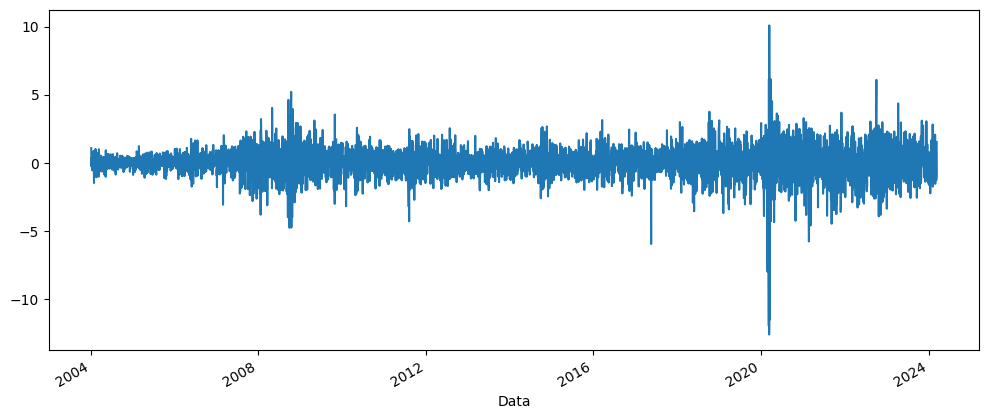

In [1459]:
serie_fechamento_diff.plot()
plt.show()

- Após a transformação percebemos que houve uma mudança no comportamento da série, é possível notar a ausencia de tendencia, isso significa que a média e a variancia da série são constantes ao longo do tempo, possívelmente ela se transformou em uma série estácionada, mas para isso iremos aplicar novamente os testes KPSS e o ADF para validar se realmente ela se tornou estácionaria.

In [1460]:
validacao_kpss(serie_fechamento_diff)

:: Validação KPSS (Kwiatkowski-Phillips-Schmidt-Shin) ::
Estatística do teste: 0.0475
p-valor 0.1000
Valores Críticos:
+-------------+-------+
| Criticidade | Valor |
+-------------+-------+
|     10%     | 0.347 |
|      5%     | 0.463 |
|     2.5%    | 0.574 |
|      1%     | 0.739 |
+-------------+-------+
>> Série estácionaria <<


C:\Users\Will\AppData\Local\Temp\ipykernel_7616\4087432485.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  resultado = kpss(serie)


- O Resultado da transformação foi positivo, o teste **KPSS** informa que conseguimos tranformar ela em estácionaria

In [1461]:
validacao_adfuller(serie_fechamento_diff)

:: Validação ADF (Dickey-Fuller) ::
ADF Statistic: -19.48680292031839
Valor-p do Teste ADF: 0.0
+-------------+---------------------+
| Criticidade |        Valor        |
+-------------+---------------------+
|      1%     |  -3.43166168173001  |
|      5%     | -2.8621196211801374 |
|     10%     | -2.5670785331097763 |
+-------------+---------------------+
Rejeitar a Hipótese Nula: a série é estacionária



- O Resultado da transformação foi positivo, o teste **ADF** informa que conseguimos tranformar ela em estácionaria

- Conseguimos através da diferenciação transformar a serie em estácionaria, agora podemos avaliar o comportamento da serie novamente

[]

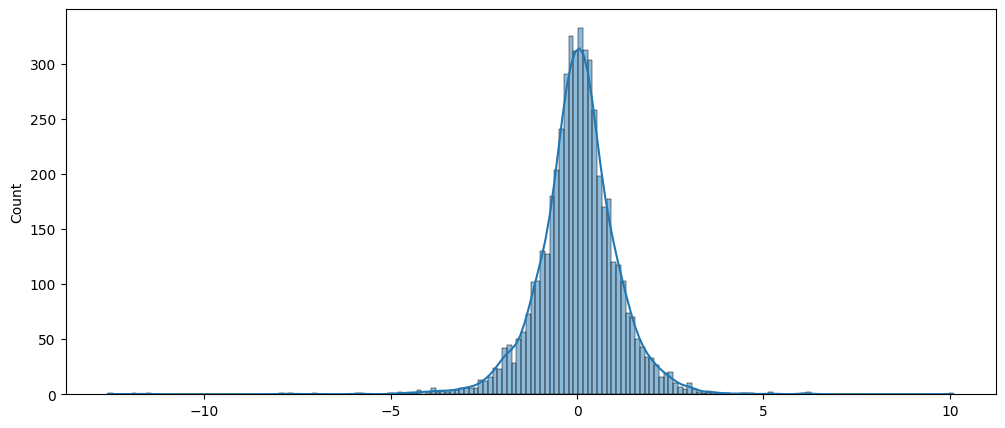

In [1462]:
sns.histplot(serie_fechamento_diff, kde=True)
plt.plot()

- Avaliando o histograma acima é possivel notar a diferença da serie, mostrando que os dados estão mais centralizado proximo a zero, com formato de sino, indicando uma normalidade entre os dados não perfeita

# Decomposição da serie Diferencial

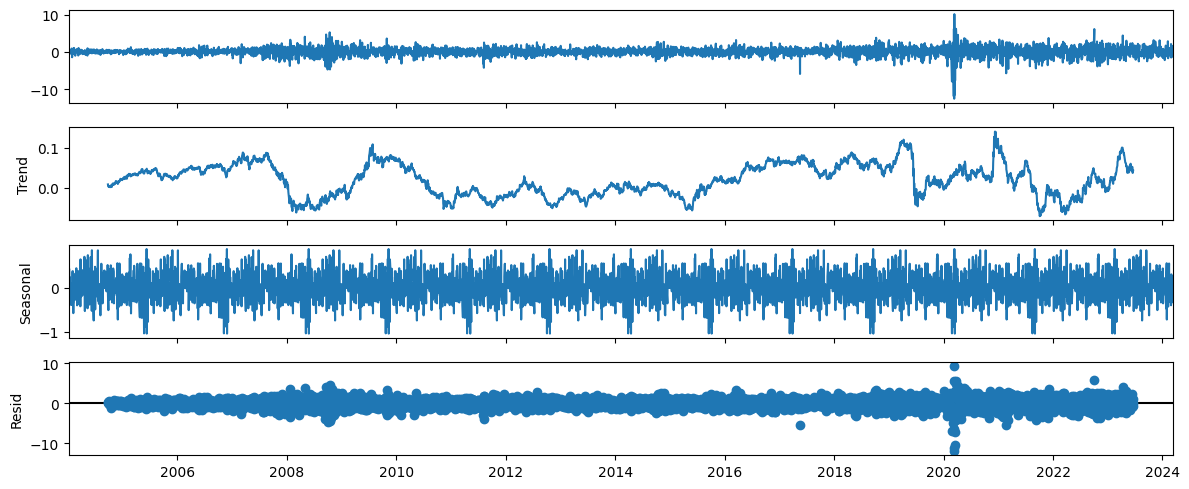

In [1463]:
serie_diff_decomposta = seasonal_decompose(serie_fechamento_diff, period=365)
serie_diff_decomposta.plot()
plt.tight_layout()

- Após a tranformação tambem é possível notar que não há mais a tendencia de alta e baixa e que os residuos estão estão aleatorios e sem padrões claros, porem é possível notar que os anos de 2008-2009 e 2020 continuam influenciar os graficos de observação, tendencia e residuos

##  Avalição residuos

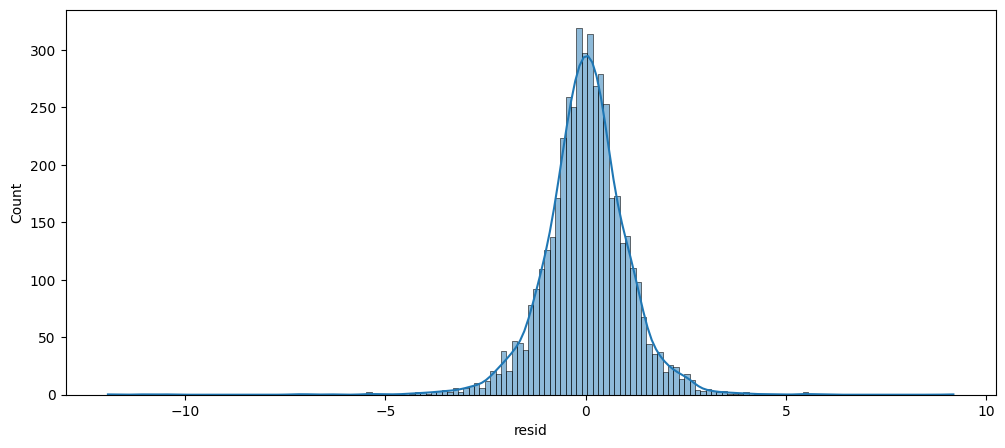

In [1464]:
sns.histplot(serie_diff_decomposta.resid, kde=True)
plt.show()

- Conseguimos avaliar visualmente que o residuo aparenta ter uma distribuição bem proxima do normal com uma concentração de valores bem proximas a zero, porem a cauda indica possíveis outliers

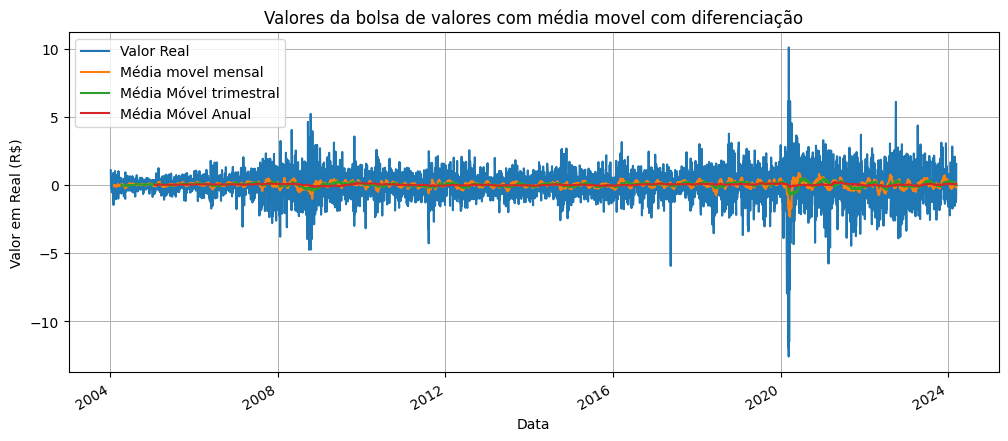

In [1465]:
plotar_medias_moveis(serie_fechamento_diff, 'Valores da bolsa de valores com média movel com diferenciação')

- Na imagem acima conseguimos visualizar o valor real diferenciado e seus médias moveis mensal, trimestral e anual, onde ela demonstra se tornado estacionária, não tendo evidencias de tendencias, ausencia de padrões sazonais nas médias móveis que sugere tambem que a sazonalidade tambem foi removida e que a variabilidade da série parece ser constante ao longo do tempo

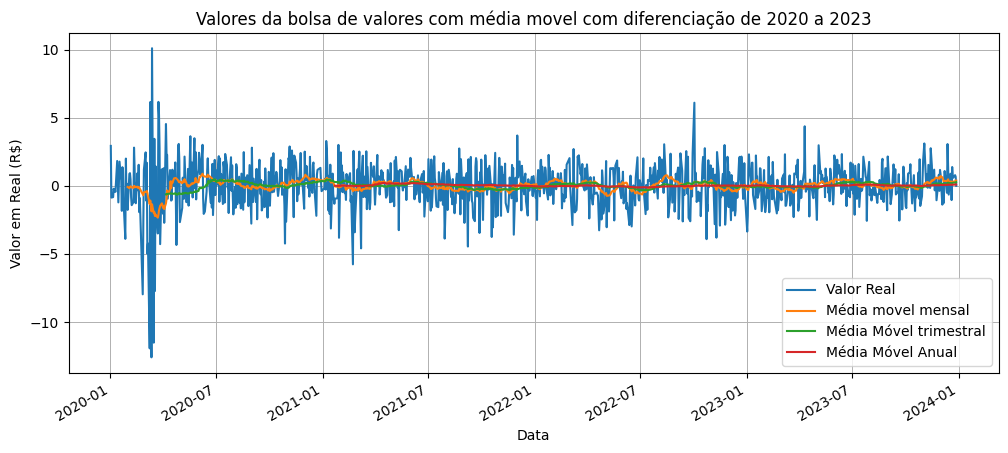

In [1466]:
plotar_medias_moveis(serie_fechamento_diff.loc[pd.Timestamp('2020-01-02'):pd.Timestamp('2023-12-29')], 'Valores da bolsa de valores com média movel com diferenciação de 2020 a 2023')

- Na imagem acima tem a mesmas caracteristica da imagem anterior, a diferença é que estamos vendo os ultimos 4 anos o que torna mais facil a visualização e entendimento do gráfico

# Autocorrelação com diferenciação


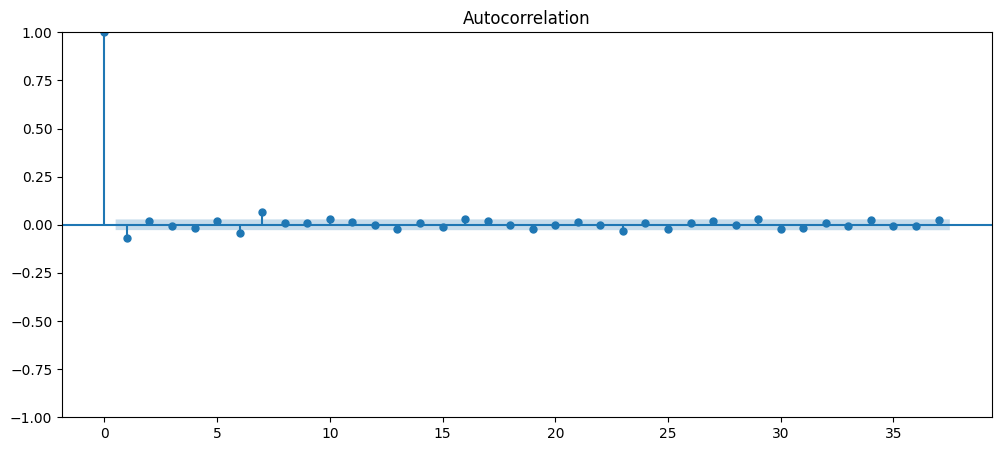

In [1467]:
plot_acf(serie_fechamento_diff)
plt.show()

- A autocorrelação da diferenciação apresentou um resultado satisfatórios, pois foi possivel notar que a partir do indicador 2 a correlação se manteve proximo ao intervalo de confiança, exceto por um item fora, porem aceitavel

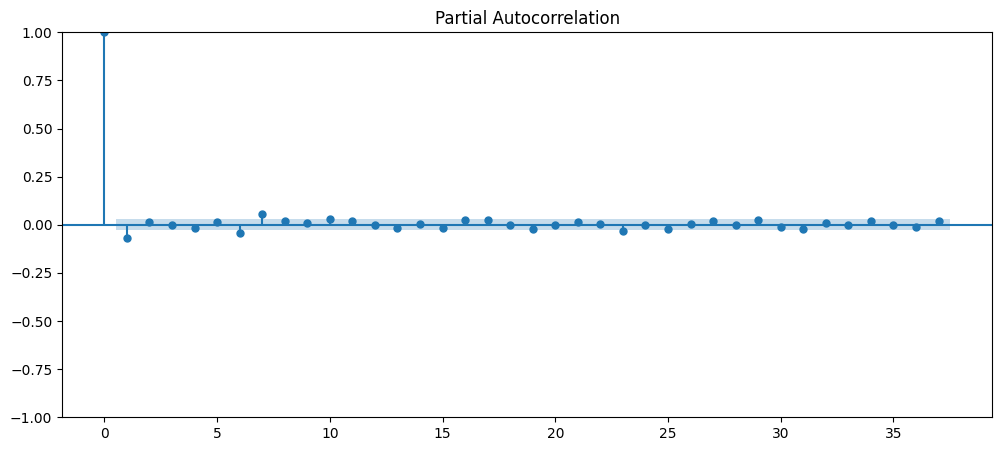

In [1468]:
plot_pacf(serie_fechamento_diff)
plt.show()

A correlação parcial tambem teve seus bon resultados considerendo-se que tambem a partir do 2 ponto se manteve dentro ou bem proximo do intervalo de confiança. Com esse resultado já é possível utilizar um modelo ARIMA com ordem 2 baseado nesse resultado

# Aplicação do Modelo ARIMA

### AutoRegressive Integrated Moving Average (ARIMA)
*É um modelo estatístico amplamente utilizado para analisar e prever séries temporais. As letras que compõem essa sigla possuem significados específicos:*
* AR (AutoRegressiva): Indica que o valor da série em um determinado momento é uma função linear de seus valores anteriores. Ou seja, os valores passados influenciam os valores futuros.
* I (Integrada): Refere-se ao processo de diferenciação aplicado à série temporal. A diferenciação é uma técnica utilizada para tornar a série estacionária, removendo tendências ou sazonalidades.
* MA (Média Móvel): Indica que o valor da série em um determinado momento é uma função linear dos erros aleatórios (ruídos) ocorridos em momentos anteriores



*Um modelo ARIMA é representado por três números: ARIMA(p,d,q).*
* p: Ordem do processo autoregressivo. Indica o número de períodos anteriores que são usados para prever o valor atual.
* d: Grau de diferenciação. Indica o número de vezes que a série é diferenciada para torná-la estacionária.
* q: Ordem do processo de médias móveis. Indica o número de termos de erro anteriores que são incluídos no modelo.

- Considerando os valores encontrados nos resultados anteriores, iremos começar testando o modelo com os seguintes valores p = 2, d = 1, e q = 1

- sendo *p = 2*  que o valor atual vai depender dos 2 valores anteriores, *d = 1* porque usamos a diferenciação uma unica vez e  *q = 1*  que o erro atual depende do erro anterior

## Aplicando o ARIMA

In [1469]:
p,d,q =  2,1,1
modelo_arima = SARIMAX(serie_fechamento_diff, order = (p,d,q), trend='c', enforce_stationarity=True)
resultado = modelo_arima.fit()
print(resultado.summary())

c:\Users\Will\OneDrive\Documentos\dev\dados\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Will\OneDrive\Documentos\dev\dados\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4999
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -7582.437
Date:                sáb, 12 out 2024   AIC                          15174.874
Time:                        23:30:09   BIC                          15207.458
Sample:                             0   HQIC                         15186.294
                               - 4999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.887e-07   1.14e-05     -0.025      0.980   -2.27e-05    2.21e-05
ar.L1         -0.0701      0.005    -12.783      0.000      -0.081      -0.059
ar.L2          0.0156      0.005      2.848      0.0

- O IAC encontrado foi de 15174, porem tem alguns warning no qual podemos avaliar 
1. Ele indica que a index de data, não tem uma frequencia, isso ocorre porque na nossa serié temos alguns dias faltando, como feriados e finais de semana, o que impede de ter todos os dias do ano e não conseguir colocar uma frequencia diaria

#### Prevendo 10 dias

In [1470]:
data_inicial = '2024-03-12'
index = pd.date_range(start=data_inicial, periods=10)
forecast_arima = resultado.forecast(10)
forecast_arima
resultado_previsao_arima = pd.Series(data=forecast_arima.values, index=index)

c:\Users\Will\OneDrive\Documentos\dev\dados\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Will\OneDrive\Documentos\dev\dados\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


- usamos o metodo forecast para prever os proximos 10 dias

[]

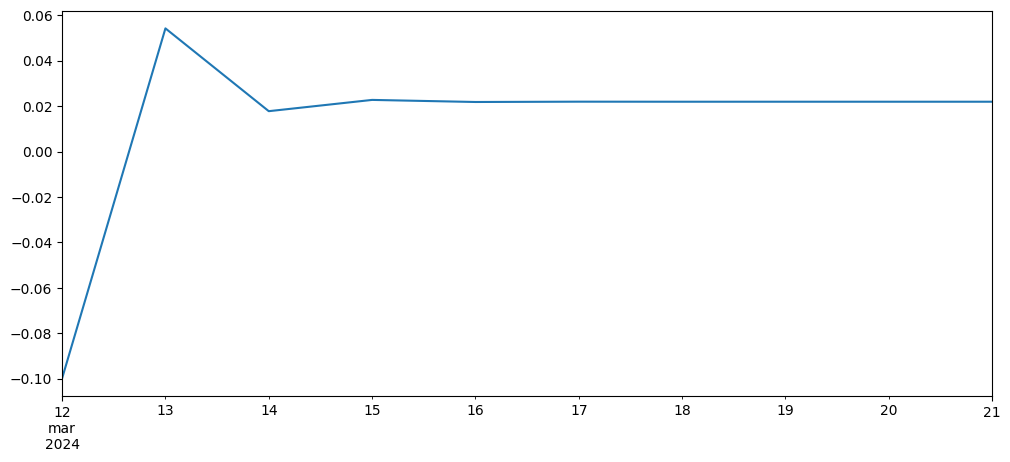

In [1471]:
resultado_previsao_arima.plot()
plt.plot()

- A previsão conseguiu prever os 2 primeiros valores, e depois disso entro em uma linha reta, isso indica que o nosso modelo não está conseguindo prever muito bem com os nossos dados. vamos aplicar o resultado como Garch para tentar melhorar o resultado

#### Aplicando o GARCH

- (Heterocedasticidade Condicional AutoRegressiva Generalizada) é um modelo estatístico utilizado para modelar a volatilidade de séries temporais financeiras. Ele assume que a variância dos retornos de um ativo não é constante ao longo do tempo, mas sim dependente de suas próprias realizações passadas. Em outras palavras, o GARCH captura a ideia de que períodos de alta volatilidade tendem a ser seguidos por outros períodos de alta volatilidade, e o mesmo ocorre com períodos de baixa volatilidade.

iremos usar o residuo do resultado do modelo, o mean = Zero que estamos assumindo qu e a média dos residuos é zero, o vol como 'GARCH', porque queremos usar um modelo GARCH para modelar a volatividade dos residuos que é capaz de capturar a variancia dos erros ao longo do tempo, e os mesmos p e q usado no ARIMA

In [1472]:
resid = resultado.resid
model_garch = arch.arch_model(resid, mean='Zero', vol='GARCH', p=p, q=q).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2724399038.7489057
Iteration:      2,   Func. Count:     14,   Neg. LLF: 6681.804830235775
Iteration:      3,   Func. Count:     19,   Neg. LLF: 14997.142198901995
Iteration:      4,   Func. Count:     27,   Neg. LLF: 13167.812663297034
Iteration:      5,   Func. Count:     33,   Neg. LLF: 6662.010536888418
Iteration:      6,   Func. Count:     39,   Neg. LLF: 6647.681727479783
Iteration:      7,   Func. Count:     45,   Neg. LLF: 6716.470522062273
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6644.409986409801
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6645.937750525545
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6643.752004420932
Iteration:     11,   Func. Count:     69,   Neg. LLF: 6643.751983583872
Iteration:     12,   Func. Count:     73,   Neg. LLF: 6643.751981329142
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6643.751983583872
            Iterations: 1

Após sua finalização iremos tentar prever novamente, só que agora com 30 dias

In [1473]:
data_inicio, data_fim = '2024-03-12','2024-04-10'
forecast_arima = resultado.forecast(steps=30)
forecast_garch = model_garch.forecast(horizon=30)
forecast = forecast_arima + np.sqrt(forecast_garch.variance.values[-1, :]) * np.random.normal(size=30)
serie_prevista_garch = pd.Series(data=forecast.values, index=pd.date_range(data_inicio, data_fim))


c:\Users\Will\OneDrive\Documentos\dev\dados\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Will\OneDrive\Documentos\dev\dados\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


- Fizemos novamente o forecast tando do arima tanto do garch e juntamos os valores num só forcast e criamos uma serie prevista com garch

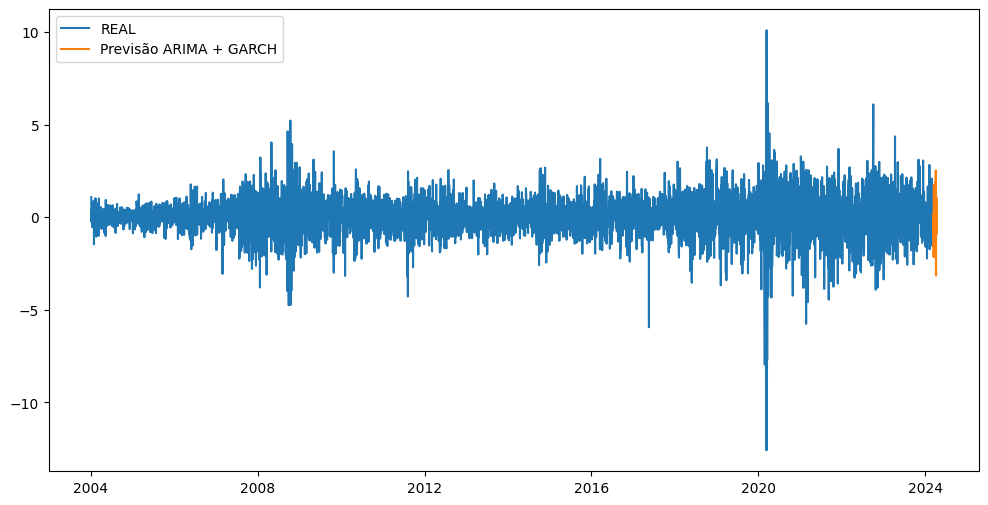

In [1474]:
plt.figure(figsize=(12, 6))
plt.plot(serie_fechamento_diff, label='REAL')
plt.plot(serie_prevista_garch, label='Previsão ARIMA + GARCH')
plt.legend()
plt.show()

- Fizemos o plot dos valores reais + previsto e o resultado foi satisfatorio, veremos mais a seguir um pouco mais de perto como ficou a previsão

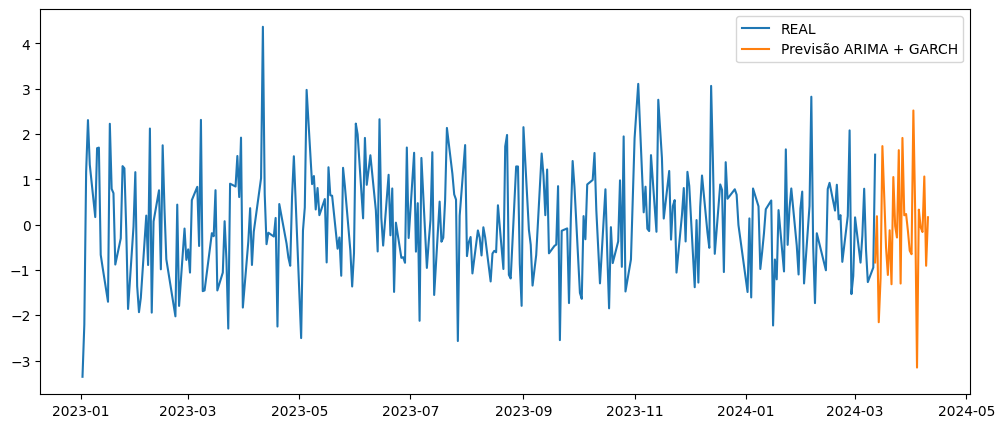

In [1475]:
plt.plot(serie_fechamento_diff.loc[pd.Timestamp('2023-01-02'):pd.Timestamp('2024-03-12')], label='REAL')
plt.plot(serie_prevista_garch, label='Previsão ARIMA + GARCH')
plt.legend()
plt.show()

Na imagem acima deu para notar a que a previsão conseguiu manter a previsão adequada e seguindo conforme o esperado

### Reversão diferenciação da previsão

In [1476]:
def reverter_diferenciacao(serie,serie_diferenciada):

    ultimo_valor = serie.iloc[-1]
    serie_normalizada = ultimo_valor + serie_diferenciada.cumsum()
    serie_normalizada

    return serie_normalizada    

In [1477]:
previsao_normal = reverter_diferenciacao(serie_fechamento, serie_prevista_garch)

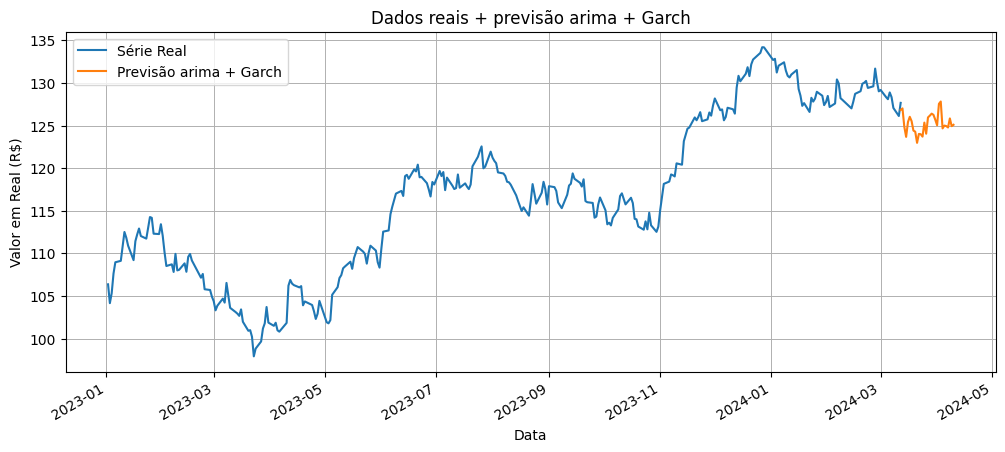

In [1478]:
plotarSerie(serie_fechamento.loc[pd.Timestamp('2023-01-02'):pd.Timestamp('2024-03-12')])
plotarSerie(previsao_normal, titulo='Dados reais + previsão arima + Garch', legendas=['Série Real', 'Previsão arima + Garch'])

### Avaliação da desempenho do modelo

In [1479]:
dias_avaliacao = 30
treino_arima = serie_fechamento_diff.head(len(serie_fechamento_diff) - dias_avaliacao)
treino_arima.head()

Data
2004-01-05    1.087
2004-01-06    0.044
2004-01-07   -0.256
2004-01-08    0.397
2004-01-09    0.200
dtype: float64

In [1480]:
test_arima = serie_fechamento_diff.tail(dias_avaliacao)
test_arima.head()

Data
2024-01-29   -0.464
2024-01-30   -1.101
2024-01-31    0.350
2024-02-01    0.729
2024-02-02   -1.299
dtype: float64

In [1481]:
p,d,q =  2,1,1

modelo_arima = SARIMAX(treino_arima, order = (p,d,q), trend='c', enforce_stationarity=True)

resultado = modelo_arima.fit(maxiter=100)

print(resultado.summary())

forecast_arima = resultado.forecast(dias_avaliacao)

resid = resultado.resid
model_garch = arch.arch_model(resid, mean='Zero', vol='GARCH', p=p, q=q).fit()
forecast_garch = model_garch.forecast(horizon=dias_avaliacao)

forecast_garch
forecast = forecast_arima + np.sqrt(forecast_garch.variance.values[-1, :]) * np.random.normal(size=dias_avaliacao)
serie_prevista_garch = pd.Series(data=forecast.values, index=test_arima.index)

c:\Users\Will\OneDrive\Documentos\dev\dados\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Will\OneDrive\Documentos\dev\dados\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4969
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -7537.911
Date:                sáb, 12 out 2024   AIC                          15085.822
Time:                        23:30:20   BIC                          15118.376
Sample:                             0   HQIC                         15097.236
                               - 4969                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.865e-06   1.26e-05      0.308      0.758   -2.08e-05    2.85e-05
ar.L1         -0.0703      0.005    -12.860      0.000      -0.081      -0.060
ar.L2          0.0190      0.005      3.481      0.0

c:\Users\Will\OneDrive\Documentos\dev\dados\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Will\OneDrive\Documentos\dev\dados\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Calculo de metricas (Erro Médio Absoluto, Erro Quadrático Médio e Erro Percentual Médio Absoluto)

* **MAE (Erro Médio Absoluto):**  Mede a média dos erros absolutos entre os valores previstos e os reais. É uma métrica robusta que não é influenciada por outliers e fornece uma ideia geral da precisão do modelo.
* **MSE (Erro Quadrático Médio):** Calcula a média dos erros ao quadrado. Penaliza mais os erros maiores, sendo útil quando grandes erros são mais problemáticos. É a base para o RMSE (raiz do erro quadrático médio), que é mais interpretado na mesma escala que os dados originais.
* **MAPE (Erro Percentual Médio Absoluto):** Calcula a média dos erros percentuais absolutos. É útil para comparar a precisão de modelos em diferentes escalas, mas pode ser instável quando há valores próximos de zero.

**Em resumo:** O MAE fornece uma medida de erro geral, o MSE penaliza mais erros grandes e o MAPE expressa o erro como uma porcentagem. A escolha da métrica depende do problema específico e da importância relativa de diferentes tipos de erros.

Para facilitar o Reuso criamos 2 metodos. um que calcula as métricas e outro que imprime o valor das metricas com seus respectivos valores


In [1482]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(colored(f"MAE: {mae}", 'light_blue'))
    print(colored(f"MSE: {mse}", 'light_cyan'))
    print(colored(f"MAPE: {mape:.2f} %", 'light_green'))

In [1483]:
metricas = {}

def salvar_metricas(modelo, new_metric):
    mae, mse, mape = new_metric
    m = {
        "mae": mae,
        "mse": mse,
        "mape": mape
    }
    
    metricas[modelo]=m


Para obter uma melhor metricas, iremos desfazer a diferenciação, colocando os dados na sua escala real, assim poderemos tirar melhor aproveitamento das metricas

In [1484]:
test_normalizada = reverter_diferenciacao(serie_fechamento.head(len(serie_fechamento) - dias_avaliacao),test_arima )
previsao_normalizada = reverter_diferenciacao(serie_fechamento.head(len(serie_fechamento) - dias_avaliacao),serie_prevista_garch )


In [1485]:
metrics = calculate_metrics(test_normalizada.values, previsao_normalizada.values)
print_metrics(metrics)
salvar_metricas('Arima', metrics)

MAE: 4.914215980039128
MSE: 5.9688495889248845
MAPE: 3.81 %


# Aplicação do modelo XGBRegressor

O **XGBRegressor** é um algoritmo de *machine learning* poderoso e eficiente, especialmente utilizado para **problemas de regressão**. Ele funciona combinando múltiplas árvores de decisão (ensemble) de forma sequencial, aprendendo dos erros dos modelos anteriores. Essa abordagem, chamada de *gradient boosting*, permite que o XGBRegressor construa modelos altamente precisos e robustos. 

**Em resumo, o XGBRegressor:**

* É um algoritmo de *ensemble* baseado em árvores de decisão.
* Utiliza a técnica de *gradient boosting* para otimizar o modelo.
* É especialmente útil para problemas de regressão.
* Combina múltiplas árvores para criar um modelo forte.
* É conhecido por sua alta performance e capacidade de lidar com diferentes tipos de dados.



In [1527]:
def create_feature(dado):
    data_frame = pd.DataFrame(dado)
    data_frame['valor_fechamento']  = data_frame['Último']
    data_frame['abertura']  = data_frame['Abertura']
    data_frame['Data'] = pd.to_datetime(data_frame['Data'], format='%d.%m.%Y')
    data_frame['year'] = data_frame["Data"].dt.year
    data_frame['month'] = data_frame["Data"].dt.month
    data_frame['day'] = data_frame["Data"].dt.day
    data_frame['dayofweek'] = data_frame["Data"].dt.dayofweek
    return data_frame

In [1528]:
feature_names = ["year", "month", "day", "dayofweek","abertura"]
target = "valor_fechamento"

In [1529]:
df_feature = create_feature(df)
df_feature = df_feature.sort_values(by='Data')
df_feature

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,valor_fechamento,abertura,year,month,day,dayofweek
4999,2004-01-02,22.445,22.233,22.450,22.208,"136,42M","0,94%",22.445,22.233,2004,1,2,4
4998,2004-01-05,23.532,22.445,23.532,22.445,"496,71M","4,84%",23.532,22.445,2004,1,5,0
4997,2004-01-06,23.576,23.532,23.976,23.180,"472,38M","0,19%",23.576,23.532,2004,1,6,1
4996,2004-01-07,23.320,23.576,23.899,23.320,"464,08M","-1,09%",23.320,23.576,2004,1,7,2
4995,2004-01-08,23.717,23.334,23.718,23.122,"436,74M","1,70%",23.717,23.334,2004,1,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2024-03-06,128.890,128.099,129.323,128.099,"11,06M","0,62%",128.890,128.099,2024,3,6,2
3,2024-03-07,128.340,128.890,129.188,128.033,"7,35M","-0,43%",128.340,128.890,2024,3,7,3
2,2024-03-08,127.071,128.335,128.338,125.802,"11,94M","-0,99%",127.071,128.335,2024,3,8,4
1,2024-03-11,126.124,127.068,127.068,126.065,"8,90M","-0,75%",126.124,127.068,2024,3,11,0


In [1530]:
X = df_feature[feature_names]
y = df_feature['valor_fechamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0059, shuffle=False)

In [1531]:
len(X_train), len(X_test)

(4970, 30)

In [1532]:
X_train.head()

,year,month,day,dayofweek,abertura
4999,2004,1,2,4,22.233
4998,2004,1,5,0,22.445
4997,2004,1,6,1,23.532
4996,2004,1,7,2,23.576
4995,2004,1,8,3,23.334


In [1533]:
X_train.tail()

,year,month,day,dayofweek,abertura
34,2024,1,22,0,127.636
33,2024,1,23,1,126.612
32,2024,1,24,2,128.275
31,2024,1,25,3,127.815
30,2024,1,26,4,128.196


In [1534]:
X_test

,year,month,day,dayofweek,abertura
29,2024,1,29,0,128.970
28,2024,1,30,1,128.492
27,2024,1,31,2,127.402
26,2024,2,1,3,127.752
25,2024,2,2,4,128.471
24,2024,2,5,0,127.182
23,2024,2,6,1,127.593
22,2024,2,7,2,130.412
21,2024,2,8,3,129.950
20,2024,2,9,4,128.216


In [1535]:
reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

preds = reg.predict(X_test)

In [1536]:
metrics = calculate_metrics(y_true=preds, y_pred=y_test.values)
print_metrics(metrics)
salvar_metricas('XGBRegressor', metrics)

MAE: 1.6837125284830714
MSE: 2.10059402879464
MAPE: 1.32 %


In [1537]:
X_train["data"] = X_train["year"].map(str) + "-" + X_train["month"].map(str) + "-" + X_train["day"].map(str)
serie_treino = pd.Series(data=y_train.values, index=pd.to_datetime(X_train['data']))
serie_treino

data
2004-01-02     22.445
2004-01-05     23.532
2004-01-06     23.576
2004-01-07     23.320
2004-01-08     23.717
               ...   
2024-01-22    126.602
2024-01-23    128.263
2024-01-24    127.816
2024-01-25    128.169
2024-01-26    128.967
Length: 4970, dtype: float64

In [1538]:
X_test["data"] = X_test["year"].map(str) + "-" + X_test["month"].map(str) + "-" + X_test["day"].map(str)
previsao_xgb = pd.DataFrame(X_test['data'])
previsao_xgb['Data'] = pd.to_datetime(previsao_xgb['data'])
previsao_xgb['valor_previsto'] = preds
previsao_xgb


,data,Data,valor_previsto
29,2024-1-29,2024-01-29,128.220520
28,2024-1-30,2024-01-30,128.194733
27,2024-1-31,2024-01-31,128.257401
26,2024-2-1,2024-02-01,127.478554
25,2024-2-2,2024-02-02,130.166046
24,2024-2-5,2024-02-05,128.077362
23,2024-2-6,2024-02-06,127.397919
22,2024-2-7,2024-02-07,131.767731
21,2024-2-8,2024-02-08,129.222549
20,2024-2-9,2024-02-09,128.098694


In [1539]:
serie_prevista_xgb = pd.Series(data=previsao_xgb['valor_previsto'].values, index=pd.to_datetime(previsao_xgb['data']))
serie_prevista_xgb

data
2024-01-29    128.220520
2024-01-30    128.194733
2024-01-31    128.257401
2024-02-01    127.478554
2024-02-02    130.166046
2024-02-05    128.077362
2024-02-06    127.397919
2024-02-07    131.767731
2024-02-08    129.222549
2024-02-09    128.098694
2024-02-14    128.014954
2024-02-15    127.205849
2024-02-16    127.009399
2024-02-19    128.296616
2024-02-20    126.845558
2024-02-21    126.126633
2024-02-22    125.770470
2024-02-23    129.437500
2024-02-26    127.285614
2024-02-27    126.741516
2024-02-28    128.558121
2024-02-29    126.371628
2024-03-01    130.067657
2024-03-04    130.302887
2024-03-05    129.673279
2024-03-06    126.969925
2024-03-07    129.363068
2024-03-08    129.344864
2024-03-11    127.297882
2024-03-12    126.969910
dtype: float32

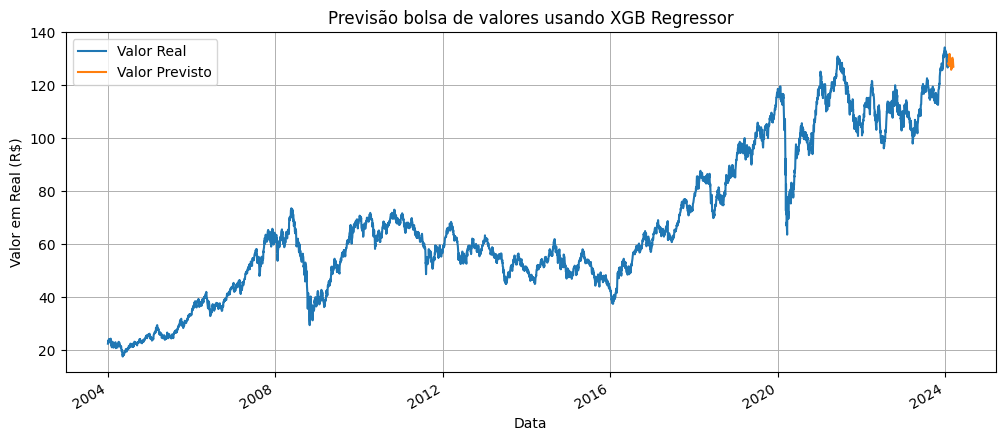

In [1540]:
plotarSerie(serie_treino)
plotarSerie(serie_prevista_xgb,titulo="Previsão bolsa de valores usando XGB Regressor", legendas=['Valor Real', 'Valor Previsto'])


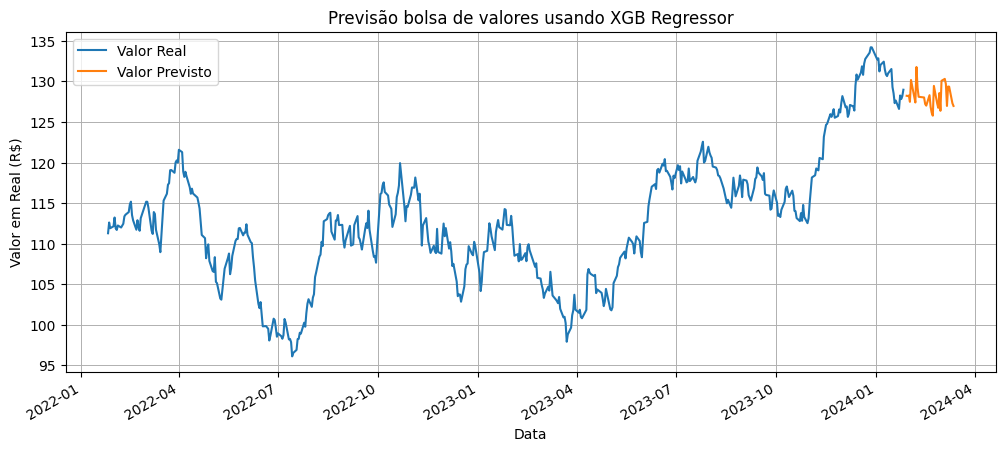

In [1541]:
plotarSerie(serie_treino[-500:])
plotarSerie(serie_prevista_xgb, titulo="Previsão bolsa de valores usando XGB Regressor", legendas=['Valor Real', 'Valor Previsto'])


# Aplicação do modelo Prophet

In [1542]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5000 non-null   object 
 1   Último    5000 non-null   float64
 2   Abertura  5000 non-null   float64
 3   Máxima    5000 non-null   float64
 4   Mínima    5000 non-null   float64
 5   Vol.      4999 non-null   object 
 6   Var%      5000 non-null   object 
dtypes: float64(4), object(3)
memory usage: 273.6+ KB


In [1543]:
df_p = pd.DataFrame(df)
df_p['ds'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df_p.head()


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,ds
0,12.03.2024,127.668,126.124,128.039,126.121,"9,48M","1,22%",2024-03-12
1,11.03.2024,126.124,127.068,127.068,126.065,"8,90M","-0,75%",2024-03-11
2,08.03.2024,127.071,128.335,128.338,125.802,"11,94M","-0,99%",2024-03-08
3,07.03.2024,128.340,128.890,129.188,128.033,"7,35M","-0,43%",2024-03-07
4,06.03.2024,128.890,128.099,129.323,128.099,"11,06M","0,62%",2024-03-06


In [1544]:
df_p.rename(columns={'Último':'y'}, inplace=True)
df_p

,Data,y,Abertura,Máxima,Mínima,Vol.,Var%,ds
0,12.03.2024,127.668,126.124,128.039,126.121,"9,48M","1,22%",2024-03-12
1,11.03.2024,126.124,127.068,127.068,126.065,"8,90M","-0,75%",2024-03-11
2,08.03.2024,127.071,128.335,128.338,125.802,"11,94M","-0,99%",2024-03-08
3,07.03.2024,128.340,128.890,129.188,128.033,"7,35M","-0,43%",2024-03-07
4,06.03.2024,128.890,128.099,129.323,128.099,"11,06M","0,62%",2024-03-06
...,...,...,...,...,...,...,...,...
4995,08.01.2004,23.717,23.334,23.718,23.122,"436,74M","1,70%",2004-01-08
4996,07.01.2004,23.320,23.576,23.899,23.320,"464,08M","-1,09%",2004-01-07
4997,06.01.2004,23.576,23.532,23.976,23.180,"472,38M","0,19%",2004-01-06
4998,05.01.2004,23.532,22.445,23.532,22.445,"496,71M","4,84%",2004-01-05


In [1545]:
df_p = df_p[['ds', 'y']]

In [1546]:
df_p = df_p.sort_values(by='ds')
df_p

,ds,y
4999,2004-01-02,22.445
4998,2004-01-05,23.532
4997,2004-01-06,23.576
4996,2004-01-07,23.320
4995,2004-01-08,23.717
...,...,...
4,2024-03-06,128.890
3,2024-03-07,128.340
2,2024-03-08,127.071
1,2024-03-11,126.124


In [1547]:
sp_feriados = holidays.Brazil(state='SP')
def preve_feriado(data):
    data_formatada = data.strftime('%Y-%m-%d')    
    return data_formatada in sp_feriados

In [1548]:

df_p['dias_uteis'] = df_p['ds'].dt.dayofweek < 5 
df_p['feriados'] = df_p['ds'].map(preve_feriado)

In [1549]:

treino, teste = train_test_split(df_p, test_size=0.0059, shuffle=False)



In [1550]:
treino

,ds,y,dias_uteis,feriados
4999,2004-01-02,22.445,True,False
4998,2004-01-05,23.532,True,False
4997,2004-01-06,23.576,True,False
4996,2004-01-07,23.320,True,False
4995,2004-01-08,23.717,True,False
...,...,...,...,...
34,2024-01-22,126.602,True,False
33,2024-01-23,128.263,True,False
32,2024-01-24,127.816,True,False
31,2024-01-25,128.169,True,False


In [1551]:
teste

,ds,y,dias_uteis,feriados
29,2024-01-29,128.503,True,False
28,2024-01-30,127.402,True,False
27,2024-01-31,127.752,True,False
26,2024-02-01,128.481,True,False
25,2024-02-02,127.182,True,False
24,2024-02-05,127.593,True,False
23,2024-02-06,130.416,True,False
22,2024-02-07,129.950,True,False
21,2024-02-08,128.217,True,False
20,2024-02-09,128.026,True,False


In [1552]:
modelo_prop = Prophet(daily_seasonality=True)
modelo_prop.add_regressor("dias_uteis")
modelo_prop.add_regressor("feriados")
modelo_prop.fit(treino)

23:31:58 - cmdstanpy - INFO - Chain [1] start processing
23:32:01 - cmdstanpy - INFO - Chain [1] done processing


In [1553]:
future_prop = modelo_prop.make_future_dataframe(periods=len(teste))
future_prop

,ds
0,2004-01-02
1,2004-01-05
2,2004-01-06
3,2004-01-07
4,2004-01-08
...,...
4995,2024-02-21
4996,2024-02-22
4997,2024-02-23
4998,2024-02-24


In [1554]:
future_prop['dias_uteis'] = df_p['dias_uteis']
future_prop['feriados'] = df_p['feriados']
future_prop

,ds,dias_uteis,feriados
0,2004-01-02,True,False
1,2004-01-05,True,False
2,2004-01-06,True,False
3,2004-01-07,True,False
4,2004-01-08,True,False
...,...,...,...
4995,2024-02-21,True,False
4996,2024-02-22,True,False
4997,2024-02-23,True,False
4998,2024-02-24,True,False


In [1555]:
forecast_prop = modelo_prop.predict(future_prop)
forecast_prop

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-01-02,21.697425,12.282059,28.034295,21.697425,21.697425,-1.531735,-1.531735,-1.531735,-2.223557,...,-0.083400,-0.083400,-0.083400,1.331111,1.331111,1.331111,0.0,0.0,0.0,20.165690
1,2004-01-05,21.747257,12.107912,28.334818,21.747257,21.747257,-1.345541,-1.345541,-1.345541,-2.223557,...,-0.159944,-0.159944,-0.159944,1.593850,1.593850,1.593850,0.0,0.0,0.0,20.401716
2,2004-01-06,21.763868,12.736297,28.345319,21.763868,21.763868,-1.231840,-1.231840,-1.231840,-2.223557,...,-0.127033,-0.127033,-0.127033,1.674639,1.674639,1.674639,0.0,0.0,0.0,20.532027
3,2004-01-07,21.780478,12.893710,28.682315,21.780478,21.780478,-1.131245,-1.131245,-1.131245,-2.223557,...,-0.101846,-0.101846,-0.101846,1.750047,1.750047,1.750047,0.0,0.0,0.0,20.649234
4,2004-01-08,21.797089,12.429171,28.814139,21.797089,21.797089,-1.044135,-1.044135,-1.044135,-2.223557,...,-0.083667,-0.083667,-0.083667,1.818978,1.818978,1.818978,0.0,0.0,0.0,20.752954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2024-02-21,121.579947,112.465471,128.210582,121.579947,121.579947,-1.030967,-1.030967,-1.030967,-2.223557,...,-0.101846,-0.101846,-0.101846,1.850325,1.850325,1.850325,0.0,0.0,0.0,120.548981
4996,2024-02-22,121.590522,113.086378,128.440120,121.590522,121.590522,-1.042719,-1.042719,-1.042719,-2.223557,...,-0.083667,-0.083667,-0.083667,1.820394,1.820394,1.820394,0.0,0.0,0.0,120.547803
4997,2024-02-23,121.601097,112.432654,128.360119,121.601097,121.601097,-1.086133,-1.086133,-1.086133,-2.223557,...,-0.083400,-0.083400,-0.083400,1.776713,1.776713,1.776713,0.0,0.0,0.0,120.514965
4998,2024-02-24,121.611672,112.379013,129.230310,121.611672,121.611672,-0.782479,-0.782479,-0.782479,-2.223557,...,0.277945,0.277945,0.277945,1.719022,1.719022,1.719022,0.0,0.0,0.0,120.829193


In [1556]:
forecast_prop['yhat']

0        20.165690
1        20.401716
2        20.532027
3        20.649234
4        20.752954
           ...    
4995    120.548981
4996    120.547803
4997    120.514965
4998    120.829193
4999    120.768075
Name: yhat, Length: 5000, dtype: float64

In [1557]:
pd.Series(data=forecast_prop['yhat'].values, index=forecast_prop['ds'])

ds
2004-01-02     20.165690
2004-01-05     20.401716
2004-01-06     20.532027
2004-01-07     20.649234
2004-01-08     20.752954
                 ...    
2024-02-21    120.548981
2024-02-22    120.547803
2024-02-23    120.514965
2024-02-24    120.829193
2024-02-25    120.768075
Length: 5000, dtype: float64

In [1558]:
predito_prop = forecast_prop.tail(len(teste))[["ds",'yhat']]
predito_prop.rename(columns={'ds':'data_prevista'}, inplace=True)
predito_prop

,data_prevista,yhat
4970,2024-01-27,120.395758
4971,2024-01-28,120.359149
4972,2024-01-29,119.889641
4973,2024-01-30,119.897000
4974,2024-01-31,119.903613
4975,2024-02-01,119.910914
4976,2024-02-02,119.908511
4977,2024-02-03,120.275677
4978,2024-02-04,120.290036
4979,2024-02-05,119.874852


In [1559]:
novo_df = pd.DataFrame(teste)
novo_df['previsto'] = predito_prop['yhat'].values
novo_df

,ds,y,dias_uteis,feriados,previsto
29,2024-01-29,128.503,True,False,120.395758
28,2024-01-30,127.402,True,False,120.359149
27,2024-01-31,127.752,True,False,119.889641
26,2024-02-01,128.481,True,False,119.897000
25,2024-02-02,127.182,True,False,119.903613
24,2024-02-05,127.593,True,False,119.910914
23,2024-02-06,130.416,True,False,119.908511
22,2024-02-07,129.950,True,False,120.275677
21,2024-02-08,128.217,True,False,120.290036
20,2024-02-09,128.026,True,False,119.874852


In [1560]:
metrics = calculate_metrics(y_true=teste['y'].values, y_pred=novo_df['previsto'])
print_metrics(metrics)
salvar_metricas('Prophet', metrics)

MAE: 8.338262139101852
MSE: 8.428048389430458
MAPE: 6.47 %


In [1561]:
forecast_prop['yhat_upper'].values
forecast_prop['yhat_lower'].values

array([ 12.28205918,  12.10791197,  12.73629742, ..., 112.43265354,
       112.37901296, 112.38840181])

In [1562]:
resultado_final  = { 
                    'valor_real': df_p['y'].values, 
                    'valor_previsto': forecast_prop['yhat'].values, 
                    'valor_previsao_maxima': forecast_prop['yhat_upper'].values, 
                    'valor_previsao_minima': forecast_prop['yhat_lower'].values
                    }

df_resultado  = pd.DataFrame(data=resultado_final, index=df_p['ds'])
df_resultado

,valor_real,valor_previsto,valor_previsao_maxima,valor_previsao_minima
ds,,,,
2004-01-02,22.445,20.165690,28.034295,12.282059
2004-01-05,23.532,20.401716,28.334818,12.107912
2004-01-06,23.576,20.532027,28.345319,12.736297
2004-01-07,23.320,20.649234,28.682315,12.893710
2004-01-08,23.717,20.752954,28.814139,12.429171
...,...,...,...,...
2024-03-06,128.890,120.548981,128.210582,112.465471
2024-03-07,128.340,120.547803,128.440120,113.086378
2024-03-08,127.071,120.514965,128.360119,112.432654


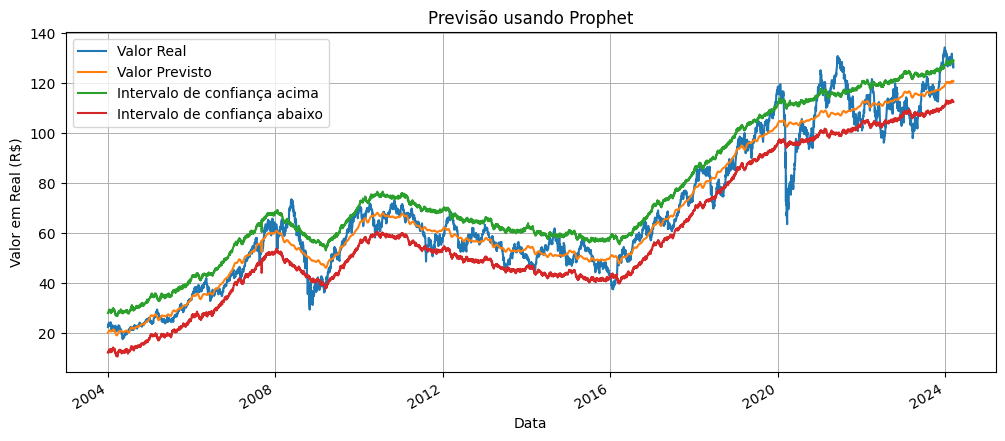

In [1563]:
plotarSerie(df_resultado['valor_real'])
plotarSerie(df_resultado['valor_previsto'])
plotarSerie(df_resultado['valor_previsao_maxima'])
plotarSerie(df_resultado['valor_previsao_minima'],titulo="Previsão usando Prophet", legendas=['Valor Real', 'Valor Previsto', 'Intervalo de confiança acima', 'Intervalo de confiança abaixo'])

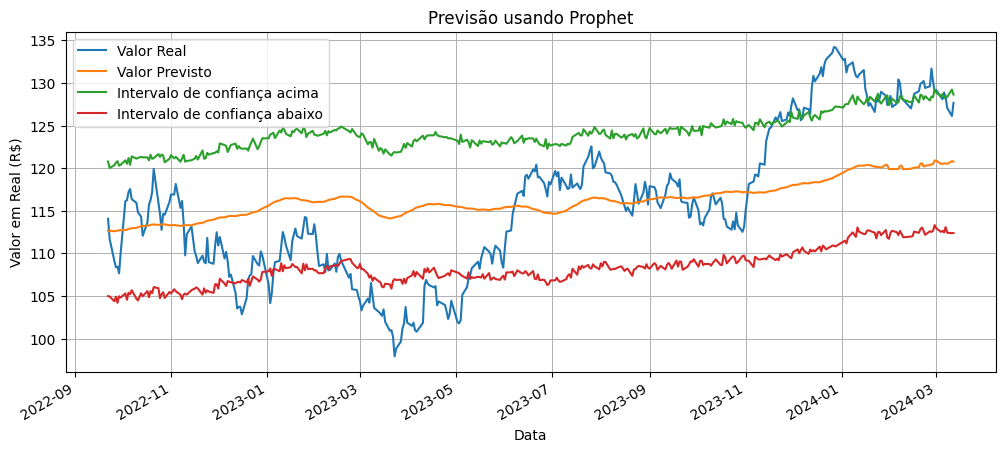

In [1564]:
plotarSerie(df_resultado['valor_real'].tail(365))
plotarSerie(df_resultado['valor_previsto'].tail(365))
plotarSerie(df_resultado['valor_previsao_maxima'].tail(365))
plotarSerie(df_resultado['valor_previsao_minima'].tail(365),titulo="Previsão usando Prophet", legendas=['Valor Real', 'Valor Previsto', 'Intervalo de confiança acima', 'Intervalo de confiança abaixo'])

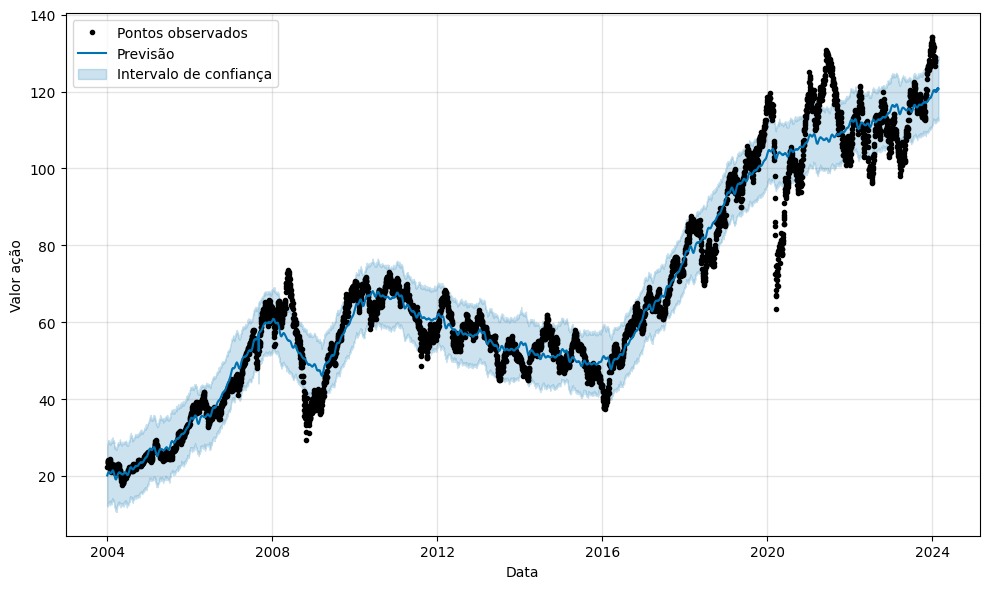

In [1565]:
modelo_prop.plot(forecast_prop)
plt.legend(loc='best', labels=['Pontos observados','Previsão', 'Intervalo de confiança'])
plt.ylabel('Valor ação')
plt.xlabel('Data')
plt.show()

In [1566]:
metricas['Arima']

{'mae': 4.914215980039128,
 'mse': 5.9688495889248845,
 'mape': 3.808572487295593}

In [1567]:
resultado_modelos = pd.DataFrame(metricas).T
resultado_modelos.head().sort_values(by="mape", ascending=True)

,mae,mse,mape
XGBRegressor,1.683713,2.100594,1.317952
Arima,4.914216,5.968850,3.808572
Prophet,8.338262,8.428048,6.472554
